# Plots of MDAnalysis CVs

## Preparation

Import dependencies

In [1]:
# Standard library
from dataclasses import dataclass
import json
import os
from pathlib import Path
import re
import sys
import warnings

# Third party packages
import cmasher as cmr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import MDAnalysis as mda
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from tqdm.auto import tqdm

# Jupyter notebook
from IPython.display import Image

# get absolute path to file's parent directory
dir_proj_base = Path(os.getcwd()).resolve().parents[2]
sys.path.insert(0, f"{dir_proj_base}/src")

# Internal dependencies
from figures.style import set_style  # noqa: E402
from stats.block_error import BlockError  # noqa: E402


Get initial working directory and set plot style

In [2]:
cwd = os.getcwd()
set_style()


Output paths

In [3]:
OPT: int = 4 # 0, 1, 2, 3, 4

In [4]:
list_ca = [0,8,16,32,64,128]

# range is roughly 1 kBT above FES minima
if OPT == 0:
    output_tag = "d_fes_min_1kBT"
    list_d12_min = [0., 1.05352676, 0.20710355, 0.69034517, 0.36918459, 0.93346673]
    list_d12_max = [1.84892446, 1.62681341, 0.59729865, 1.06853427, 1.23961981, 1.6058029]
# range is roughly 2 kBT above FES minima
elif OPT == 1: 
    output_tag = "d_fes_min_2kBT"
    list_d12_min = [0.,         0.,         0.11705853, 0.61530765, 0.28814407, 0.73836918]
    list_d12_max = [1.6178089,  0.96648324, 0.7953977,  1.24262131, 1.50075038, 2.49424712]
# associated states
elif OPT == 2:
    output_tag = "dmin_0nm_dmax_1.8nm"
    list_d12_min = [0] * 6
    list_d12_max = [1.8] * 6
# disassociated states
elif OPT == 3:
    output_tag = "dmin_4nm_dmax_5.5nm"
    list_d12_min = [4] * 6
    list_d12_max = [5.5] * 6
# all states
elif OPT == 4:
    output_tag = "all_states"
    list_d12_min = [0] * 6
    list_d12_max = [6] * 6
# range is roughly 0.1 kBT above FES minima
elif OPT == 5:
    output_tag = "d_fes_min_0.1kBT"
    list_d12_min = [0., 1.18859430, 0.33016508, 0.83141571, 0.97548774, 1.23661831]
    list_d12_max = [1.8489244,  1.29364682, 0.44722361, 0.94847424,  1.09854927, 1.40770385]

In [5]:
dir_output_base = Path(f"./../data/output_mdanalysis_cvs/{output_tag}")
dir_figures = dir_output_base / "figures"
dir_data = dir_output_base / "data"

dir_figures.mkdir(exist_ok=True, parents=True)
dir_data.mkdir(exist_ok=True, parents=True)

print(f"Output dir base: {dir_output_base}")


Output dir base: ../data/output_mdanalysis_cvs/all_states


## Data Source

### Hyper parameters

Image of two-chain distance PMF with minima of each FES set to zero to find FES well regions for associated chains

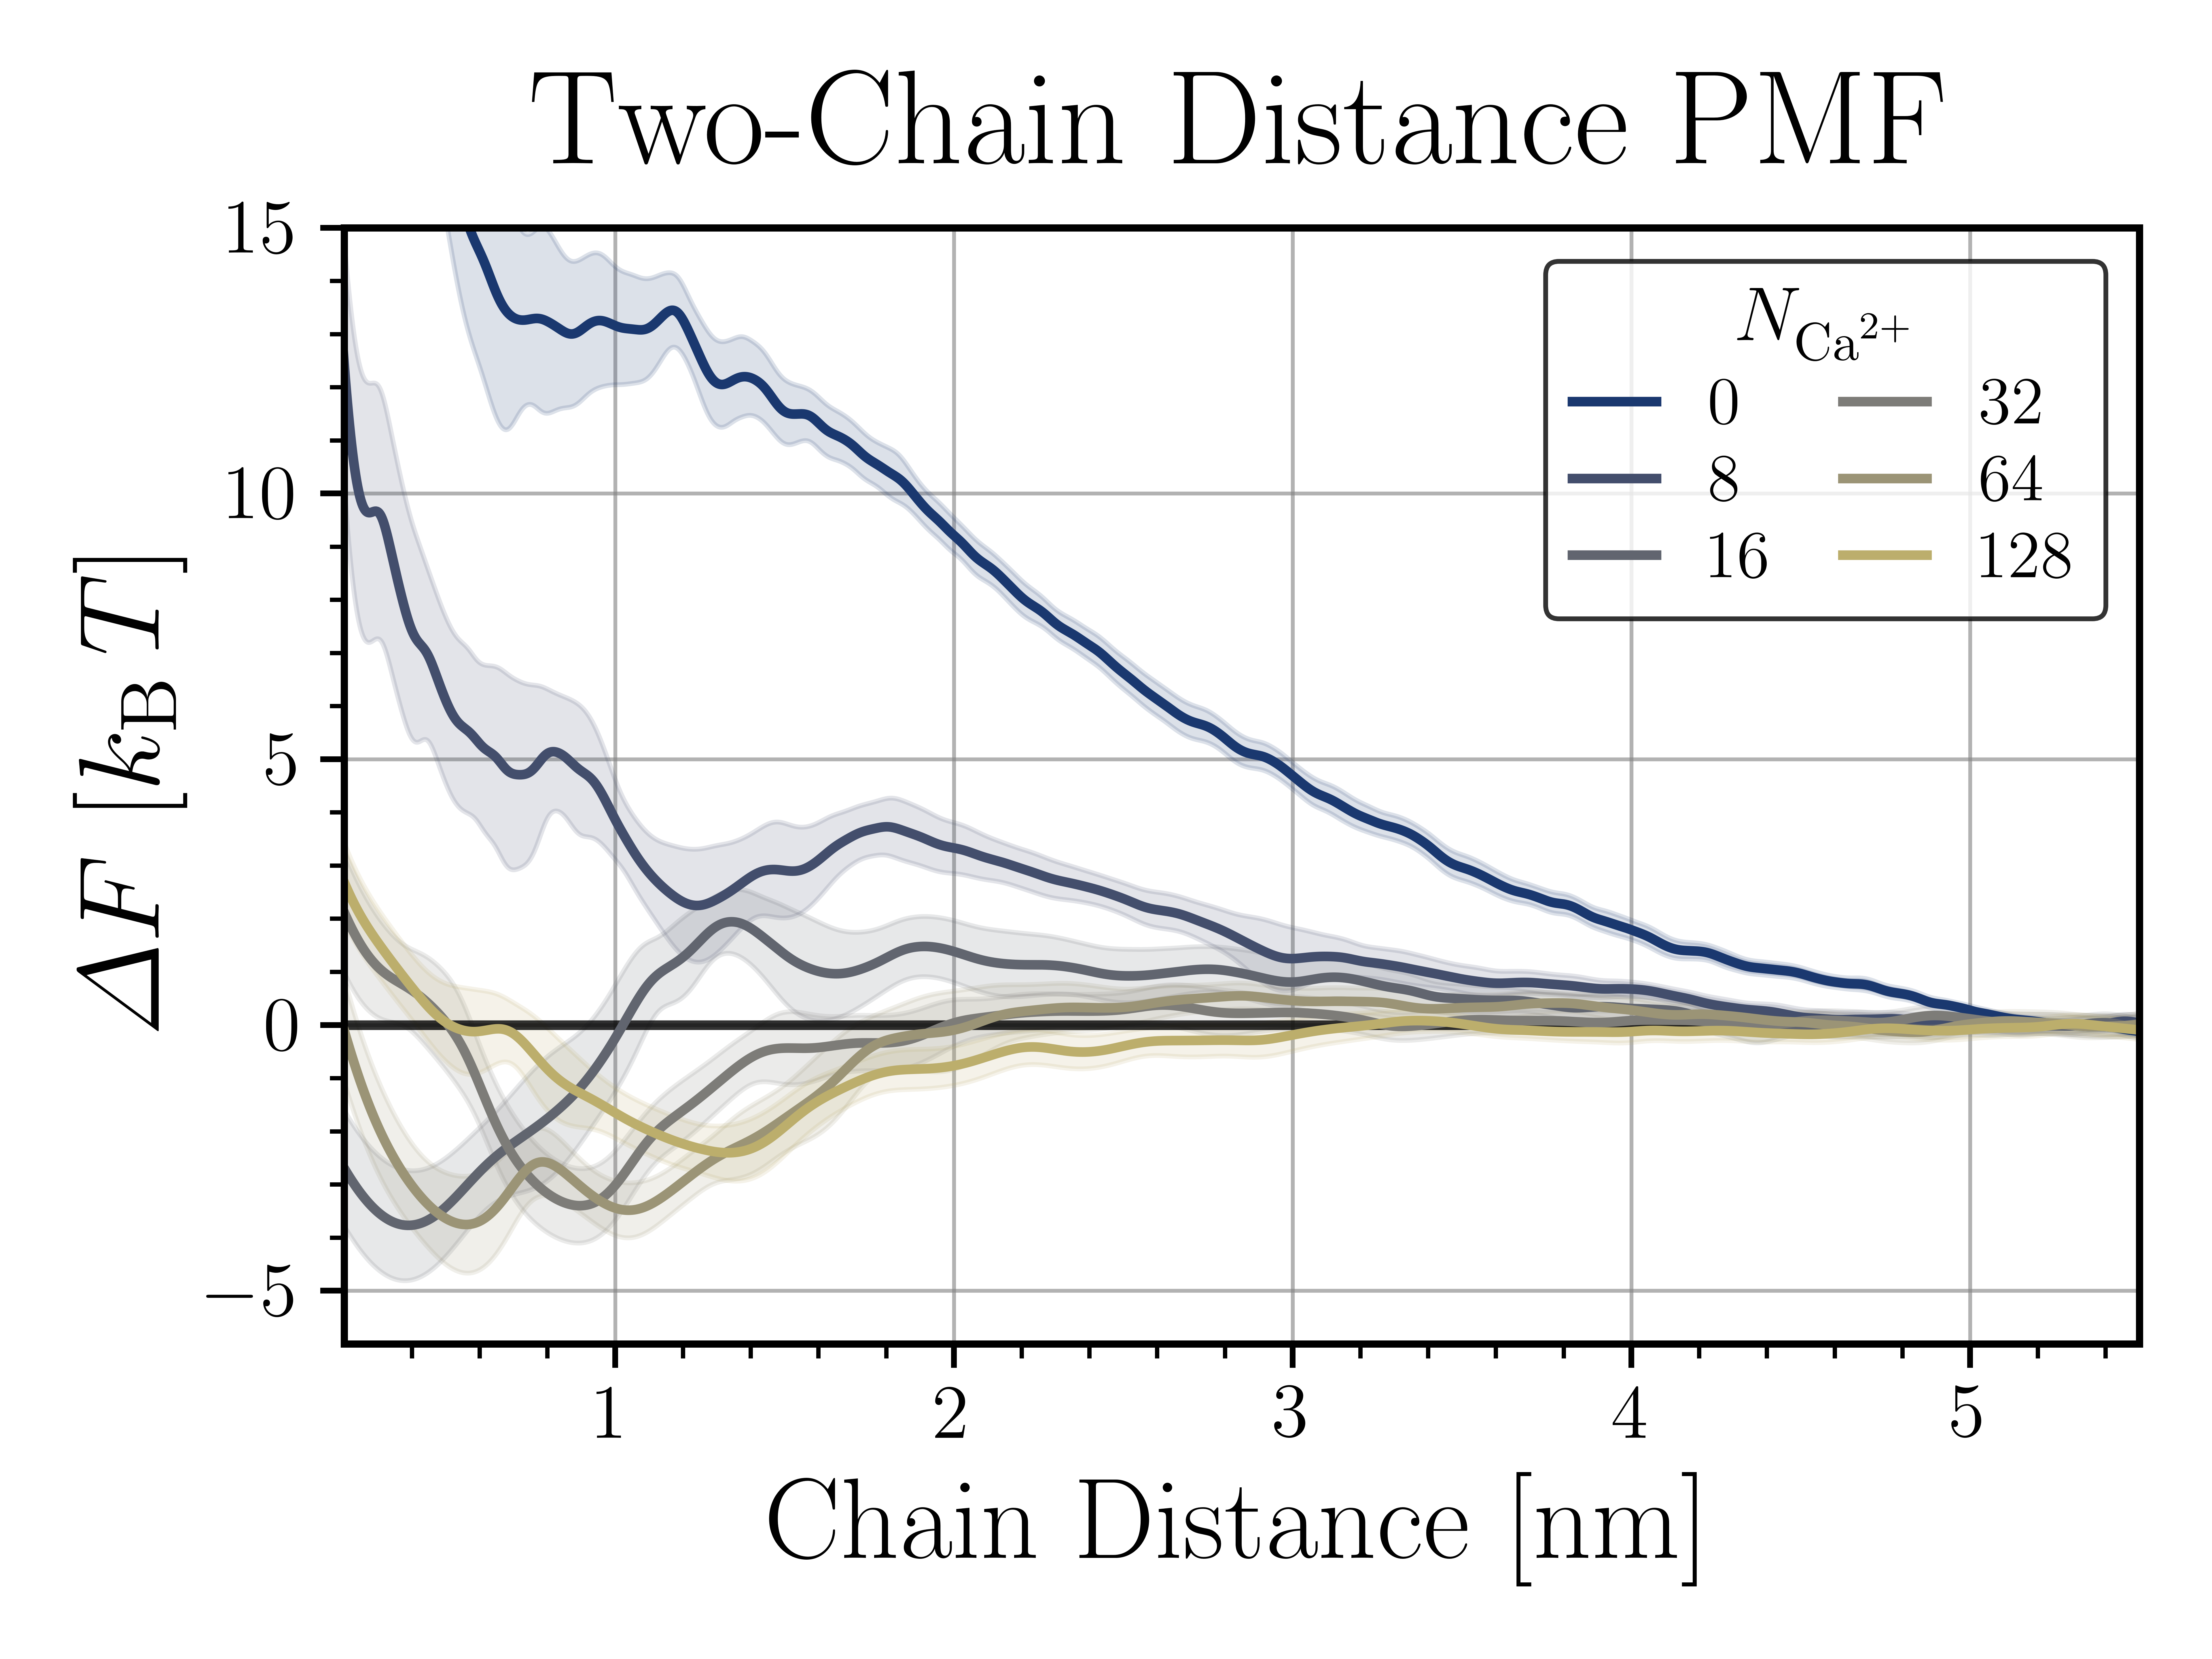

In [6]:
Image(filename="./../data/plumed/output_plumed_pmf/figures/pmf_b2.png", width=600)

### Data class

In [7]:
@dataclass(frozen=False, order=True)
class Data:
    tag: str
    info: dict
    selection: dict

    # global polymer size
    df_rg_a: pd.DataFrame
    df_rg_b: pd.DataFrame
    
    # local polymer clustering
    arr_rdf_calpha: tuple[np.ndarray, np.ndarray]
    df_cn_calpha_about_calpha: pd.DataFrame

    # calcium-polymer complexes
    df_cn_o_carboxy_about_ca_6_12: pd.DataFrame
    df_cn_o_carboxy_about_ca_hard: pd.DataFrame
    df_cn_c_carboxy_about_ca_6_12: pd.DataFrame
    df_cn_c_carboxy_about_ca_hard: pd.DataFrame
    
    # sodium-polymer complexes
    df_cn_o_carboxy_about_na_6_12: pd.DataFrame
    df_cn_o_carboxy_about_na_hard: pd.DataFrame
    df_cn_c_carboxy_about_na_6_12: pd.DataFrame
    df_cn_c_carboxy_about_na_hard: pd.DataFrame

    # ion and polymer RDFs
    arr_rdf_o_carboxy_about_ca: tuple[np.ndarray, np.ndarray]
    arr_rdf_o_carboxy_about_na: tuple[np.ndarray, np.ndarray]
    
    # ion and water RDFs
    arr_rdf_o_water_about_ca: tuple[np.ndarray, np.ndarray]
    arr_rdf_o_water_about_na: tuple[np.ndarray, np.ndarray]
    arr_rdf_o_water_about_ca_adsorbed: tuple[np.ndarray, np.ndarray]
    

### Sorting methods

In [8]:
def natural_sort(l):
    def convert(text):
        if text.isdigit():
            return int(text)
        else:
            return text.lower()

    def alphanum_key(key):
        if type(key) is not str:
            key = str(key)
        return [convert(c) for c in re.split("([0-9]+)", key)]

    return sorted(l, key=alphanum_key)


### `mda_data_gen.py` files

#### General paths

In [9]:
# variable inputs
data_base_path = Path("./../data/mdanalysis/output/")
print(f"Data path: '{data_base_path}'")

info_dir = "mdanalysis/data/"
rg_dir = "mdanalysis_polymer_lengths/data/"
cn_dir = "mdanalysis_contacts/data/"
rdf_dir = "mdanalysis_rdf/data/"


Data path: '../data/mdanalysis/output'


#### Locate files

In [10]:
# find all subdirectories (tags)
simulation_paths = natural_sort([x for x in data_base_path.iterdir() if x.is_dir() and "2PAcr-16mer" in x.name])
# drop paths with "Ace-" or "Alc-" in the name
simulation_paths = [x for x in simulation_paths if "Ace-" not in x.name and "Alc-" not in x.name]

tags = [x.name for x in simulation_paths]
print(f"Found {len(tags)} simulation directories")



Found 6 simulation directories


In [11]:
# find CV data files
info_paths = [None] * len(tags)
selection_paths = [None] * len(tags)

rg_data_paths = [None] * len(tags)

rdf_calpha_about_calpha_data_paths = [None] * len(tags)
cn_calpha_about_calpha_data_paths = [None] * len(tags)

cn_c_carboxy_about_ca_data_paths = [None] * len(tags)
cn_o_carboxy_about_ca_data_paths = [None] * len(tags)
cn_c_carboxy_about_na_data_paths = [None] * len(tags)
cn_o_carboxy_about_na_data_paths = [None] * len(tags)

rdf_o_carboxy_about_ca_data_paths = [None] * len(tags)
rdf_o_carboxy_about_na_data_paths = [None] * len(tags)

rdf_o_water_about_ca_data_paths = [None] * len(tags)
rdf_o_water_about_na_data_paths = [None] * len(tags)
rdf_o_water_about_ca_absorbed_data_paths = [None] * len(tags)


for i, path in tqdm(
    enumerate(simulation_paths),
    total=len(simulation_paths),
    desc="Finding CV data files",
    colour="green",
):
    # info and selection json files
    info_paths[i] = [x for x in path.rglob(f"{info_dir}/info_dict_*.json")]
    selection_paths[i] = [x for x in path.rglob(f"{info_dir}/sel_dict_*.json")]
    assert len(info_paths[i]) == 1
    assert len(selection_paths[i]) == 1

    # rg data for chain A and B
    rg_data_paths[i] = [x for x in path.rglob(f"{rg_dir}/*.parquet")]
    rg_data_paths[i].sort()
    assert len(rg_data_paths[i]) == 2
    
    # C_\alpha information
    rdf_calpha_about_calpha_data_paths[i] = [x for x in path.rglob(f"{rdf_dir}/*C_alpha_chain_A_about_C_alpha_chain_B.parquet")]
    cn_calpha_about_calpha_data_paths[i] = natural_sort([x for x in path.rglob(f"{cn_dir}/*C_alpha_chain_A_and_C_alpha_chain_B*.parquet")])
    assert len(rdf_calpha_about_calpha_data_paths[i]) == 1
    assert len(cn_calpha_about_calpha_data_paths[i]) == 2

    # contact data for carboxylic carbons and oxygens about calcium
    # both hard and 6-12 rational functions
    cn_c_carboxy_about_ca_data_paths[i] = natural_sort(
        [x for x in path.rglob(f"{cn_dir}/*carboxy_C_and_Ca*.parquet")]
    )
    cn_o_carboxy_about_ca_data_paths[i] = natural_sort(
        [x for x in path.rglob(f"{cn_dir}/*carboxy_O_and_Ca*.parquet")]
    )
    if int(json.load(open(info_paths[i][0]))["n_Ca"]) > 0:
        assert len(cn_c_carboxy_about_ca_data_paths[i]) == 2
        assert len(cn_o_carboxy_about_ca_data_paths[i]) == 2
    else:
        assert len(cn_c_carboxy_about_ca_data_paths[i]) == 0
        assert len(cn_o_carboxy_about_ca_data_paths[i]) == 0

    # contact data for carboxylic carbons and oxygens about sodium
    # both hard and 6-12 rational functions
    cn_c_carboxy_about_na_data_paths[i] = natural_sort(
        [x for x in path.rglob(f"{cn_dir}/*carboxy_C_and_Na*.parquet")]
    )
    cn_o_carboxy_about_na_data_paths[i] = natural_sort(
        [x for x in path.rglob(f"{cn_dir}/*carboxy_O_and_Na*.parquet")]
    )
    assert len(cn_c_carboxy_about_na_data_paths[i]) == 2
    assert len(cn_o_carboxy_about_na_data_paths[i]) == 2
    
    # rdf data for carboxylic oxygens about ions
    rdf_o_carboxy_about_ca_data_paths[i] = [x for x in path.rglob(f"{rdf_dir}/*carboxy_O_about_Ca.parquet")]
    rdf_o_carboxy_about_na_data_paths[i] = [x for x in path.rglob(f"{rdf_dir}/*carboxy_O_about_Na.parquet")]
    assert len(rdf_o_carboxy_about_ca_data_paths[i]) == 1
    assert len(rdf_o_carboxy_about_na_data_paths[i]) == 1
    
    # # rdf data for water oxygens about ions
    rdf_o_water_about_ca_data_paths[i] = [x for x in path.rglob(f"{rdf_dir}/*water_O_about_Ca.parquet")]
    rdf_o_water_about_na_data_paths[i] = [x for x in path.rglob(f"{rdf_dir}/*water_O_about_Na.parquet")]
    rdf_o_water_about_ca_absorbed_data_paths[i] = [x for x in path.rglob(f"{rdf_dir}/*water_O_about_adsorbed_Ca.parquet")]
    assert len(rdf_o_water_about_ca_data_paths[i]) == 1, f"{len(rdf_o_water_about_ca_data_paths[i])} {path}"
    assert len(rdf_o_water_about_na_data_paths[i]) == 1, f"{len(rdf_o_water_about_na_data_paths[i])} {path}"
    assert len(rdf_o_water_about_ca_absorbed_data_paths[i]) == 1, f"{len(rdf_o_water_about_ca_absorbed_data_paths[i])} {path}"
     

Finding CV data files:   0%|          | 0/6 [00:00<?, ?it/s]

#### Load data and place in data class

In [12]:
data_list = [None] * len(tags)
for i in tqdm(range(len(tags)), desc="Loading CV data", colour="green"):
    ca = int(json.load(open(info_paths[i][0]))["n_Ca"]) > 0
    data_list[i] = Data(
            tag=tags[i],
            info=json.load(open(info_paths[i][0])),
            selection=json.load(open(selection_paths[i][0])),
            # global polymer size
            df_rg_a=pd.read_parquet(rg_data_paths[i][0]),
            df_rg_b=pd.read_parquet(rg_data_paths[i][1]),
            # local polymer clustering
            arr_rdf_calpha=pd.read_parquet(rdf_calpha_about_calpha_data_paths[i][0]),
            df_cn_calpha_about_calpha=pd.read_parquet(cn_calpha_about_calpha_data_paths[i][0]),
            # calcium-polymer complexes
            df_cn_o_carboxy_about_ca_6_12=pd.read_parquet(cn_o_carboxy_about_ca_data_paths[i][0]) if ca else None,
            df_cn_o_carboxy_about_ca_hard=pd.read_parquet(cn_o_carboxy_about_ca_data_paths[i][1]) if ca else None,
            df_cn_c_carboxy_about_ca_6_12=pd.read_parquet(cn_c_carboxy_about_ca_data_paths[i][0]) if ca else None,
            df_cn_c_carboxy_about_ca_hard=pd.read_parquet(cn_c_carboxy_about_ca_data_paths[i][1]) if ca else None,
            # sodium-polymer complexes
            df_cn_o_carboxy_about_na_6_12=pd.read_parquet(cn_o_carboxy_about_na_data_paths[i][0]),
            df_cn_o_carboxy_about_na_hard=pd.read_parquet(cn_o_carboxy_about_na_data_paths[i][1]),
            df_cn_c_carboxy_about_na_6_12=pd.read_parquet(cn_c_carboxy_about_na_data_paths[i][0]),
            df_cn_c_carboxy_about_na_hard=pd.read_parquet(cn_c_carboxy_about_na_data_paths[i][1]),
            # ion and polymer RDFs
            arr_rdf_o_carboxy_about_ca=pd.read_parquet(rdf_o_carboxy_about_ca_data_paths[i][0]) if ca else None,
            arr_rdf_o_carboxy_about_na=pd.read_parquet(rdf_o_carboxy_about_na_data_paths[i][0]),
            # ion and water RDFs
            arr_rdf_o_water_about_ca=pd.read_parquet(rdf_o_water_about_ca_data_paths[i][0]),
            arr_rdf_o_water_about_na=pd.read_parquet(rdf_o_water_about_na_data_paths[i][0]),
            arr_rdf_o_water_about_ca_adsorbed=pd.read_parquet(rdf_o_water_about_ca_absorbed_data_paths[i][0])
        )

Loading CV data:   0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
# limit df_cn and df_rg to d12 in range
for i, data in enumerate(data_list):
    data.df_rg_a = data.df_rg_a.loc[(data.df_rg_a["d12"] >= list_d12_min[i]) & (data.df_rg_a["d12"] <= list_d12_max[i])].copy()
    data.df_rg_b = data.df_rg_b.loc[(data.df_rg_b["d12"] >= list_d12_min[i]) & (data.df_rg_b["d12"] <= list_d12_max[i])].copy()
    data.df_cn_calpha_about_calpha = data.df_cn_calpha_about_calpha.loc[(data.df_cn_calpha_about_calpha["d12"] >= list_d12_min[i]) & (data.df_cn_calpha_about_calpha["d12"] <= list_d12_max[i])].copy()
    
    if data.df_cn_o_carboxy_about_ca_6_12 is not None:
        data.df_cn_o_carboxy_about_ca_6_12 = data.df_cn_o_carboxy_about_ca_6_12.loc[(data.df_cn_o_carboxy_about_ca_6_12["d12"] >= list_d12_min[i]) & (data.df_cn_o_carboxy_about_ca_6_12["d12"] <= list_d12_max[i])].copy()
    if data.df_cn_o_carboxy_about_ca_hard is not None:
        data.df_cn_o_carboxy_about_ca_hard = data.df_cn_o_carboxy_about_ca_hard.loc[(data.df_cn_o_carboxy_about_ca_hard["d12"] >= list_d12_min[i]) & (data.df_cn_o_carboxy_about_ca_hard["d12"] <= list_d12_max[i])].copy()
    if data.df_cn_c_carboxy_about_ca_6_12 is not None:
        data.df_cn_c_carboxy_about_ca_6_12 = data.df_cn_c_carboxy_about_ca_6_12.loc[(data.df_cn_c_carboxy_about_ca_6_12["d12"] >= list_d12_min[i]) & (data.df_cn_c_carboxy_about_ca_6_12["d12"] <= list_d12_max[i])].copy()
    if data.df_cn_c_carboxy_about_ca_hard is not None:
        data.df_cn_c_carboxy_about_ca_hard = data.df_cn_c_carboxy_about_ca_hard.loc[(data.df_cn_c_carboxy_about_ca_hard["d12"] >= list_d12_min[i]) & (data.df_cn_c_carboxy_about_ca_hard["d12"] <= list_d12_max[i])].copy()
    
    data.df_cn_o_carboxy_about_na_6_12 = data.df_cn_o_carboxy_about_na_6_12.loc[(data.df_cn_o_carboxy_about_na_6_12["d12"] >= list_d12_min[i]) & (data.df_cn_o_carboxy_about_na_6_12["d12"] <= list_d12_max[i])].copy()
    data.df_cn_o_carboxy_about_na_hard = data.df_cn_o_carboxy_about_na_hard.loc[(data.df_cn_o_carboxy_about_na_hard["d12"] >= list_d12_min[i]) & (data.df_cn_o_carboxy_about_na_hard["d12"] <= list_d12_max[i])].copy()
    data.df_cn_c_carboxy_about_na_6_12 = data.df_cn_c_carboxy_about_na_6_12.loc[(data.df_cn_c_carboxy_about_na_6_12["d12"] >= list_d12_min[i]) & (data.df_cn_c_carboxy_about_na_6_12["d12"] <= list_d12_max[i])].copy()
    data.df_cn_c_carboxy_about_na_hard = data.df_cn_c_carboxy_about_na_hard.loc[(data.df_cn_c_carboxy_about_na_hard["d12"] >= list_d12_min[i]) & (data.df_cn_c_carboxy_about_na_hard["d12"] <= list_d12_max[i])].copy()

## Dump which frames are within d range

In [14]:
for dat, d12_min, d12_max in zip(data_list, list_d12_min, list_d12_max):
    
    df_in_range = dat.df_rg_a
    frames = df_in_range["frame"]
    frames = frames.astype(int)
    print(f"System {dat.info['system']} has {len(frames)} frames in range {d12_min} to {d12_max}")

    frames.to_csv(f"../data/frames_{dat.info['system']}_d12_1kbt.csv", index=False)

System 16_PAcr-0_Ca has 239915 frames in range 0 to 6
System 16_PAcr-8_Ca has 240325 frames in range 0 to 6
System 16_PAcr-16_Ca has 253144 frames in range 0 to 6
System 16_PAcr-32_Ca has 250698 frames in range 0 to 6
System 16_PAcr-64_Ca has 67456 frames in range 0 to 6
System 16_PAcr-128_Ca has 11199 frames in range 0 to 6


## Plot the 2D Free Energy Surface of the system 

### Sum contact number between carboxylate oxygens and Ca ions (y-axis) vs. two-chain distance (x-axis)

  0%|          | 0/6 [00:00<?, ?it/s]

System: 16_PAcr-8_Ca
Number of data points: 210604



/tmp/ipykernel_1281426/3959358756.py:71: RuntimeWarning: divide by zero encountered in log
  f = -np.log(f)


System: 16_PAcr-16_Ca
Number of data points: 225849

System: 16_PAcr-32_Ca
Number of data points: 224119

System: 16_PAcr-64_Ca
Number of data points: 60849

System: 16_PAcr-128_Ca
Number of data points: 10013



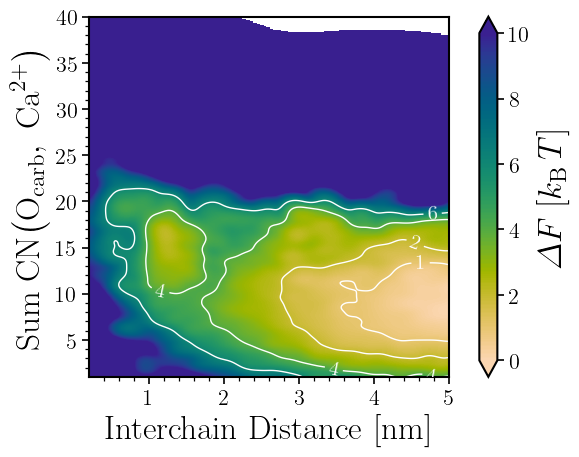

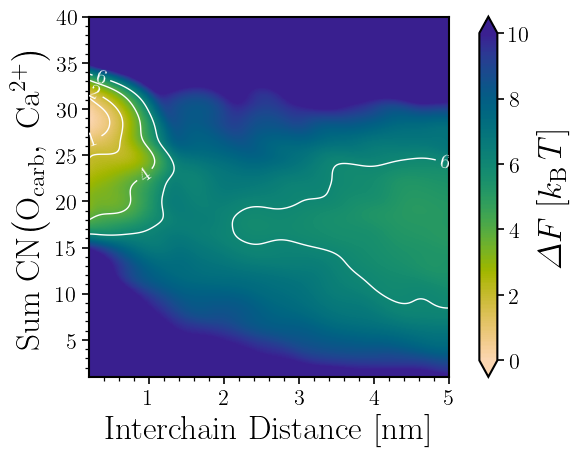

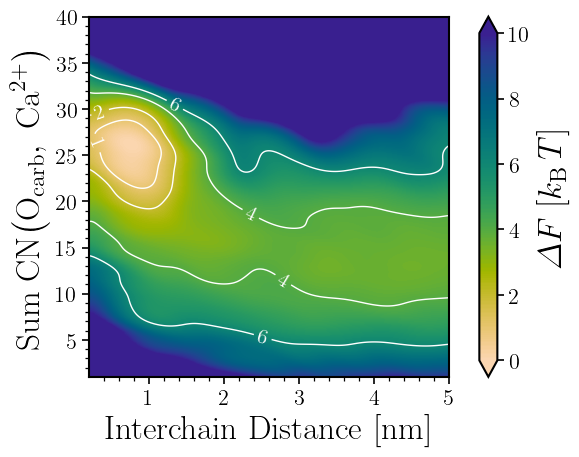

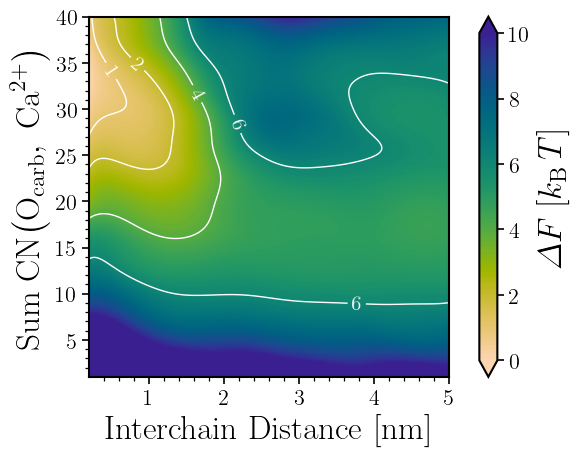

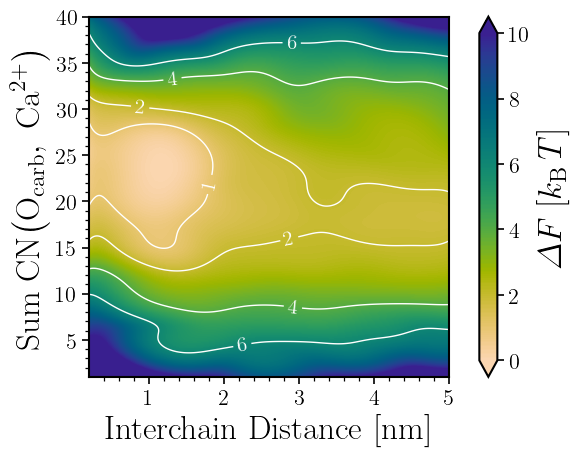

In [15]:
# parameters
bandwidth = "scott"  # options: float, scott, silverman, or callable
verbose = True
# colors
cmap = cmr.get_sub_cmap("cmr.rainforest_r", 0.1, 0.75)
# x-axis
xval = "d12"
xlabel = "Interchain Distance [nm]"
xticks = np.arange(1, 6)
# y-axis
yval = "sum_contacts"
ylabel = r"$\mathrm{Sum~CN}{\left(\mathrm{O}_\mathrm{carb},~{\mathrm{Ca}^{2+}}\right)}$"
yticks = np.arange(0, 45, 5)
# z-axis
zmin = 0.0
zmax = 10.0
zticks = np.linspace(zmin, zmax, 6, endpoint=True)
levels = [1, 2, 4, 6]
# save
pname = "2d_fes_x_d12_y_sum_cn_co_ca"

for dat in tqdm(data_list):

    if dat.info["n_Ca"] == 0:
        continue
   
    # set system information 
    tag = dat.info["system"].replace("-", "_")
    title = f"{dat.info['n_Ca']} Ca$^{{2+}}$"
    filename = f"{dir_figures}/{pname}_{tag}"
   
    # set dataframe 
    df = dat.df_cn_o_carboxy_about_ca_6_12.copy()
    
    # calculate sum of contacts
    if yval == "sum_contacts":
        df["sum_contacts"] = df.filter(regex="^ag2_*").sum(axis=1)
    
    # x-axis: limit range of distance CV
    df = df[(df[xval] >= 0.0) & (df[xval] <= 5.5)]
    # y-axis: limit range of coordination number CV
    df = df[(df[yval] >= 0.5) & (df[yval] <= np.inf)]
    
    # output information
    if verbose:
        print(f"System: {dat.info['system']}")
        print(f"Number of data points: {len(df)}")
        print()
    
    # collect data from dataframe
    x = df[xval].to_numpy()
    y = df[yval].to_numpy()
    weight = df["weight"].to_numpy()

    # calculate 2D kernel density estimate
    xx, yy = np.mgrid[0.2:5.0:300j, 1:40:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    
    # if bandwidth is a float, divide by standard deviation
    if isinstance(bandwidth, float):
        bw = bandwidth / np.std(positions)
    else:
        bw = bandwidth 
   
    # calculate KDE
    kernel = stats.gaussian_kde(values, weights=weight, bw_method=bw)
    f = np.reshape(kernel(positions).T, xx.shape)

    # convert to free energy
    f = -np.log(f)
    # apply distance correction
    if xval == "d12":
        f += 2.0 * np.log(xx)
    # set minimum to zero
    f -= np.nanmin(f)
    
    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_box_aspect(1)
    
    # set labels
    ax.set_xlabel(xlabel)
    ax.set_xticks(xticks)
    ax.set_ylabel(ylabel)
    ax.set_yticks(yticks)
    ax.set_title(title, y=1.05)

    # imshow plot
    im = ax.imshow(f.T, cmap=cmap,
                   vmin=zmin, vmax=zmax, 
                   extent=[np.nanmin(xx), np.nanmax(xx), np.nanmin(yy), np.nanmax(yy)],
                   origin="lower", aspect="auto") 
    
    # color bar
    cbar = plt.colorbar(im, label=r"$\Delta F$ [$k_\mathrm{B} \, T$]",
                        ticks=zticks, extend="both", 
                        boundaries=np.linspace(zmin, zmax, 256))

    # contour plot
    line_colors = ["white" for l in levels]
    label_colors = ["white" for l in levels]
    cp = ax.contour(xx, yy, f, levels=levels, colors=line_colors, linewidths=1)
    cl = ax.clabel(cp, fontsize=15, colors=label_colors)
    
    # save figure
    fig.tight_layout()
    fig.savefig(f"{filename}.png", dpi=600)

    # remove title and save figure
    ax.set_title("")
    fig.tight_layout()
    fig.savefig(f"{filename}.pdf", dpi=1200, transparent=True)


  0%|          | 0/6 [00:00<?, ?it/s]

System: 16_PAcr-8_Ca
Number of data points: 421488
System: 16_PAcr-16_Ca
Number of data points: 451712
System: 16_PAcr-32_Ca
Number of data points: 448250
System: 16_PAcr-64_Ca
Number of data points: 121698
System: 16_PAcr-128_Ca
Number of data points: 20026


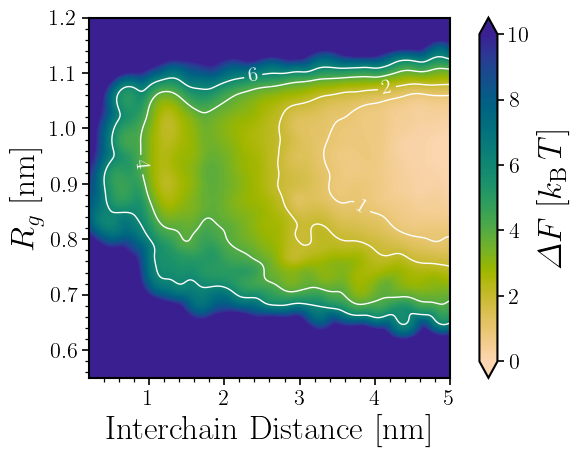

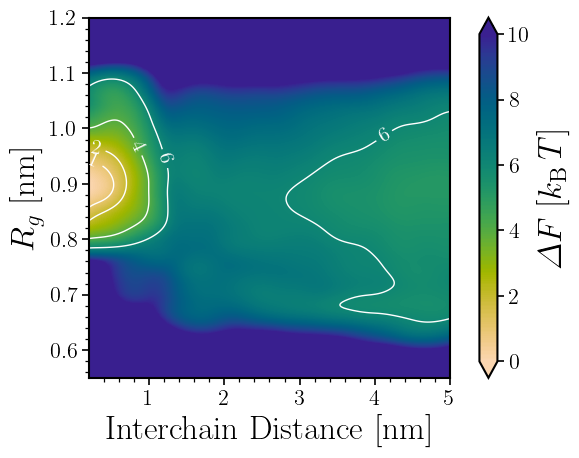

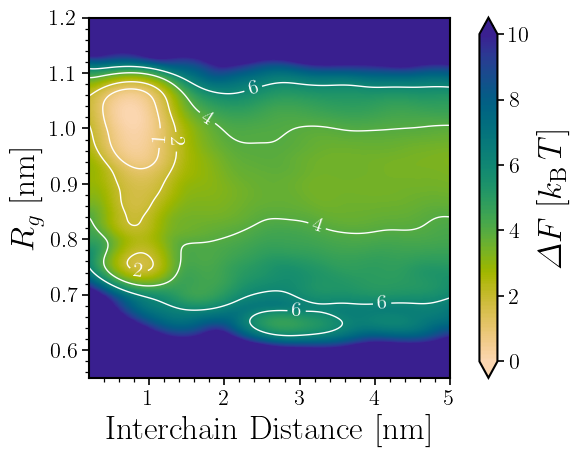

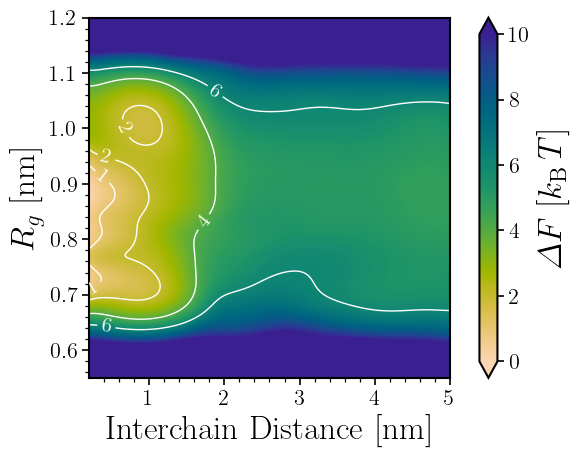

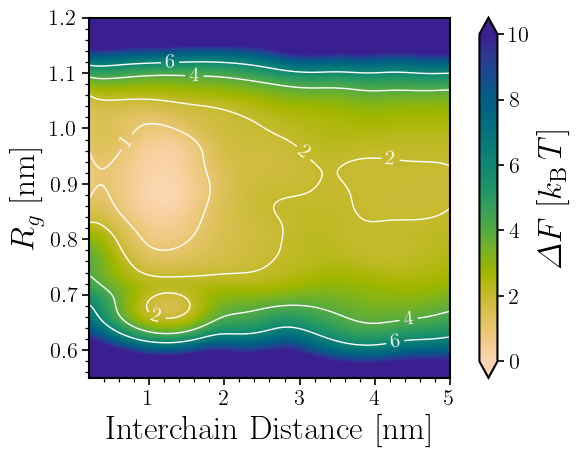

In [16]:
# parameters
bandwidth = "scott"  # options: float, scott, silverman, or callable
verbose = True
# x-axis
xval = "d12"
xlabel = "Interchain Distance [nm]"
xticks = np.arange(1, 6)
# y-axis
yval = "rg"
ylabel = r"$R_g$ [nm]"
yticks = np.arange(start=0.6, stop=1.3, step=0.1, dtype=float)
# z-axis
zmin = 0.0
zmax = 10.0
zticks = np.linspace(zmin, zmax, 6, endpoint=True)
levels = [1, 2, 4, 6]
# save
pname = "2d_fes_x_d12_y_rg"

for dat in tqdm(data_list):

    if dat.info["n_Ca"] == 0:
        continue
   
    # set system information 
    tag = dat.info["system"].replace("-", "_")
    title = f"{dat.info['n_Ca']} Ca$^{{2+}}$"
    filename = f"{dir_figures}/{pname}_{tag}"
   
    # set dataframe 
    dfa = dat.df_rg_a.copy()
    dfb = dat.df_rg_b.copy()
    df = pd.concat([dfa, dfb], ignore_index=True)
    df.astype({"d12": "float64", "rg": "float64"})

    # calculate sum of contacts
    if yval == "sum_contacts":
        df[yval] = df.filter(regex="^ag2_*").sum(axis=1)
    
    # x-axis: limit range of distance CV
    df = df[(df[xval] >= 0.0) & (df[xval] <= 5.5)]
    # y-axis: limit range of coordination number CV
    df = df[(df[yval] >= 0.1) & (df[yval] <= 1000)]
    
    # output information
    if verbose:
        print(f"System: {dat.info['system']}")
        print(f"Number of data points: {len(df)}")
    
    # collect data from dataframe
    x = df[xval].to_numpy()
    y = df[yval].to_numpy()
    if yval == "rg":
        y /= 10.0
        
    weight = df["weight"].to_numpy()

    # calculate 2D kernel density estimate
    xx, yy = np.mgrid[0.2:5.0:300j, 0.55:1.2:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    
    # if bandwidth is a float, divide by standard deviation
    if isinstance(bandwidth, float):
        bw = bandwidth / np.std(positions)
    else:
        bw = bandwidth 
   
    # calculate KDE
    kernel = stats.gaussian_kde(values, weights=weight, bw_method=bw)
    f = np.reshape(kernel(positions).T, xx.shape)

    # convert to free energy
    f = -np.log(f)
    # apply distance correction
    if xval == "d12":
        f += 2.0 * np.log(xx)
    # set minimum to zero
    f -= np.nanmin(f)
    
    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_box_aspect(1)
    
    # set labels
    ax.set_xlabel(xlabel)
    ax.set_xticks(xticks)
    ax.set_ylabel(ylabel)
    ax.set_yticks(yticks)
    ax.set_title(title, y=1.05)

    # imshow plot
    im = ax.imshow(f.T, cmap=cmap,
                   vmin=zmin, vmax=zmax, 
                   extent=[np.nanmin(xx), np.nanmax(xx), np.nanmin(yy), np.nanmax(yy)],
                   origin="lower", aspect="auto") 
    
    # color bar
    cbar = plt.colorbar(im, label=r"$\Delta F$ [$k_\mathrm{B} \, T$]",
                        ticks=zticks, extend="both", 
                        boundaries=np.linspace(zmin, zmax, 256))

    # contour plot
    line_colors = ["white" for l in levels]
    label_colors = ["white" for l in levels]
    cp = ax.contour(xx, yy, f, levels=levels, colors=line_colors, linewidths=1)
    cl = ax.clabel(cp, fontsize=15, colors=label_colors)
    
    # save figure
    fig.tight_layout()
    fig.savefig(f"{filename}.png", dpi=600)

    # remove title and save figure
    ax.set_title("")
    fig.tight_layout()
    fig.savefig(f"{filename}.pdf", dpi=1200, transparent=True)

  0%|          | 0/6 [00:00<?, ?it/s]

System: 16_PAcr-8_Ca
Number of data points: 480650


/tmp/ipykernel_1281426/3186475125.py:64: RuntimeWarning: divide by zero encountered in log
  f = -np.log(f)


System: 16_PAcr-16_Ca
Number of data points: 506288
System: 16_PAcr-32_Ca
Number of data points: 501396
System: 16_PAcr-64_Ca
Number of data points: 134912
System: 16_PAcr-128_Ca
Number of data points: 22398


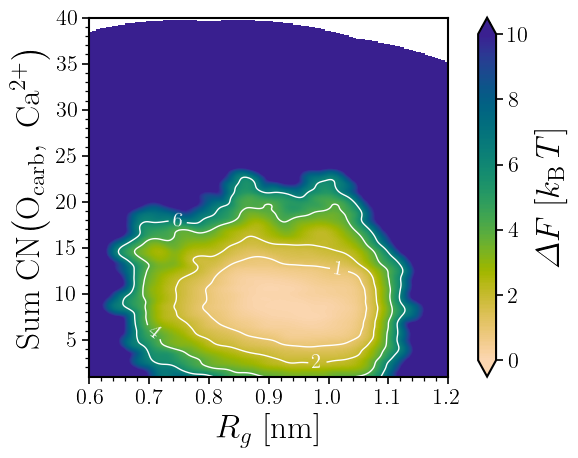

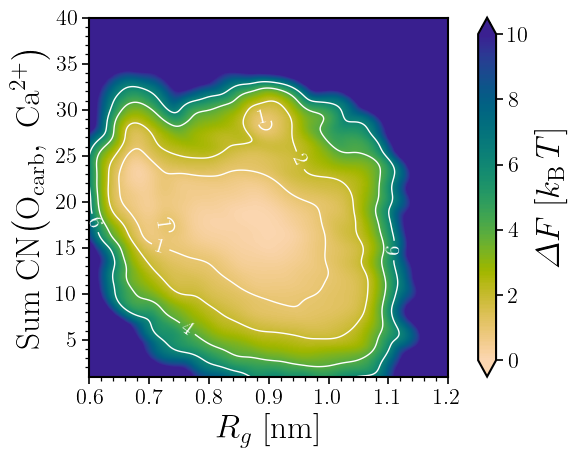

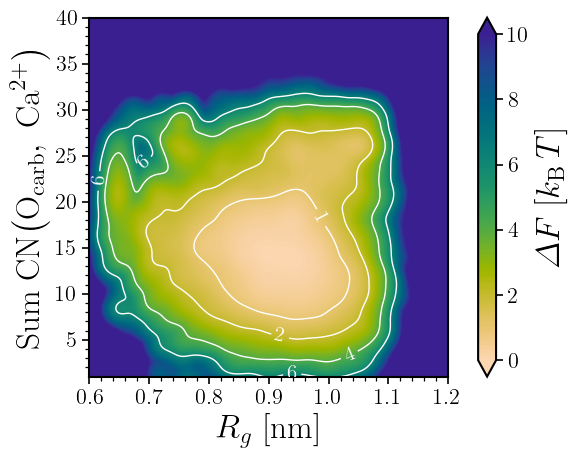

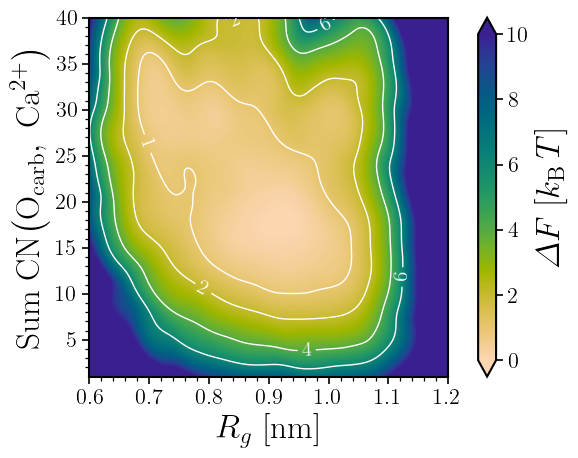

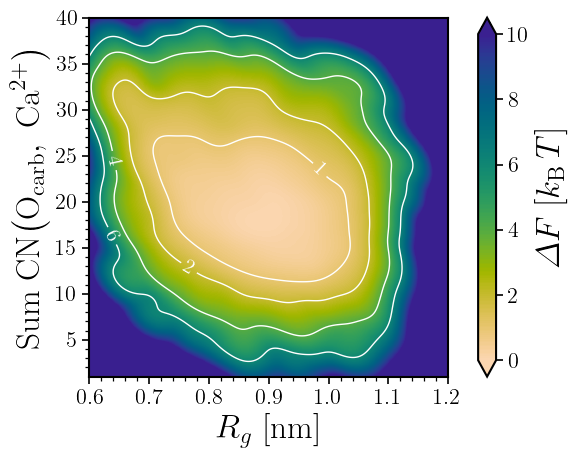

In [17]:
# parameters
bandwidth = "scott"  # options: float, scott, silverman, or callable
verbose = True
# x-axis
xval = "rg"
xlabel = r"$R_g$ [nm]"
xticks = np.arange(start=0.6, stop=1.4, step=0.1, dtype=float)
# y-axis
yval = "sum_contacts"
ylabel = r"$\mathrm{Sum~CN}{\left(\mathrm{O}_\mathrm{carb},~{\mathrm{Ca}^{2+}}\right)}$"
yticks = np.arange(0, 45, 5)
# z-axis
zmin = 0.0
zmax = 10.0
zticks = np.linspace(zmin, zmax, 6, endpoint=True)
levels = [1, 2, 4, 6]
# save
pname = "2d_fes_x_rg_y_sum_cn_co_ca"

for dat in tqdm(data_list):

    if dat.info["n_Ca"] == 0:
        continue
   
    # set system information 
    tag = dat.info["system"].replace("-", "_")
    title = f"{dat.info['n_Ca']} Ca$^{{2+}}$"
    filename = f"{dir_figures}/{pname}_{tag}"
   
    # set dataframe 
    dfa = dat.df_rg_a.copy()
    dfb = dat.df_rg_b.copy()
    df_cn = dat.df_cn_o_carboxy_about_ca_6_12.copy()
    dfa["sum_contacts"] = df_cn.filter(regex="^ag2_*").sum(axis=1).copy()
    dfb["sum_contacts"] = dfa["sum_contacts"].copy()
    df = pd.concat([dfa, dfb], ignore_index=True)
    df.astype({"sum_contacts": float, "weight": float, "rg": float, "d12": float})
    
    # output information
    if verbose:
        print(f"System: {dat.info['system']}")
        print(f"Number of data points: {len(df)}")
    
    # collect data from dataframe
    x = df[xval].to_numpy() / 10.0
    y = df[yval].to_numpy()
    weight = df["weight"].to_numpy()

    # if bandwidth is a float, divide by standard deviation
    if isinstance(bandwidth, float):
        bw = bandwidth / np.std(positions)
    else:
        bw = bandwidth 
   
    # calculate 2D kernel density estimate
    xx, yy = np.mgrid[0.6:1.2:300j, 1:40:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    # calculate KDE
    kernel = stats.gaussian_kde(values, weights=weight, bw_method=bw)
    f = np.reshape(kernel(positions).T, xx.shape)

    # convert to free energy
    f = -np.log(f)
    # set minimum to zero
    f -= np.nanmin(f)
    
    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_box_aspect(1)
    
    # set labels
    ax.set_xlabel(xlabel)
    ax.set_xticks(xticks)
    ax.set_ylabel(ylabel)
    ax.set_yticks(yticks)
    ax.set_title(title, y=1.05)

    # imshow plot
    im = ax.imshow(f.T, cmap=cmap,
                   vmin=zmin, vmax=zmax, 
                   extent=[np.nanmin(xx), np.nanmax(xx), np.nanmin(yy), np.nanmax(yy)],
                   origin="lower", aspect="auto")
    
    
    # color bar
    cbar = plt.colorbar(im, label=r"$\Delta F$ [$k_\mathrm{B} \, T$]",
                        ticks=zticks, extend="both", 
                        boundaries=np.linspace(zmin, zmax, 256))

    # contour plot
    line_colors = ["white" for l in levels]
    label_colors = ["white" for l in levels]
    cp = ax.contour(xx, yy, f, levels=levels, colors=line_colors, linewidths=1)
    cl = ax.clabel(cp, fontsize=15, colors=label_colors)
    
    # save figure
    fig.tight_layout()
    fig.savefig(f"{filename}.png", dpi=600)

    # remove title and save figure
    ax.set_title("")
    fig.tight_layout()
    fig.savefig(f"{filename}.pdf", dpi=1200, transparent=True)

## Plot the number of bound, shielding, and bridging Ca ions as a function of the number of Ca ions in the system

### Functions to transform the data

In [18]:
def df_ion_adsorbed(
    data: list[Data],
    d12_min: list[float],
    d12_max: list[float],
    method: str = "hard",
    ion: str = "ca",
) -> list[pd.DataFrame]:
    """
    Iterates through data dataclasses and returns a list of dataframes
    containing the number of bound, bridging, and shielding calcium ions
    for each frame in the trajectory along with its associated weight
    from the enhanced sampling bias.

    The frames returned are where the chains are "associated" as defined
    by the d12_min and d12_max parameters.

    The method parameter can be either "hard" or "6_12" to select the
    contact definition used to determine the number of bound, bridging,
    and shielding calcium ions.

    Parameters
    ----------
    data : list[Data]
        List of Data dataclasses.
    d12_min : list[float]
        Minimum d12 value for a frame to be considered "associated".
    d12_max : list[float]
        Maximum d12 value for a frame to be considered "associated".
    method : str, optional
        Contact definition to use to determine the number of bound,
        bridging, and shielding calcium ions. Can be either "hard" or
        "6_12". The default is "hard".
    ion : str, optional
        Ion to calculate the number of bound, bridging, and shielding
        ions for. Can be either "ca" or "na". The default is "ca".

    Returns
    -------
    list[pd.DataFrame]
        List of dataframes containing the number of bound, bridging,
        and shielding calcium ions for each frame in the trajectory
        along with its associated weight from the enhanced sampling
        bias.

    Raises
    ------
    ValueError
        If the method parameter is not recognized.
    ValueError
        If the d12_min and d12_max parameters are not the same length.
    ValueError
        If the d12_min and data parameters are not the same length.
    """
    if len(d12_min) != len(d12_max):
        raise ValueError("d12_min and d12_max must be the same length.")
    if len(d12_min) != len(data):
        raise ValueError("d12_min and d12_max must be the same length as data.")

    dfs = [None] * len(data)
    for i, dat in tqdm(
        enumerate(data),
        total=len(data),
        desc="Calculating Ca ion types",
        colour="green",
    ):
        # get dataframe
        try:
            if ion.lower() == "ca":
                if method == "hard":
                    df = dat.df_cn_o_carboxy_about_ca_hard.copy()
                elif method == "6_12":
                    df = dat.df_cn_o_carboxy_about_ca_6_12.copy()
                else:
                    raise ValueError(f"Method '{method}' not recognized.")
            elif ion.lower() == "na":
                if method == "hard":
                    df = dat.df_cn_o_carboxy_about_na_hard.copy()
                elif method == "6_12":
                    df = dat.df_cn_o_carboxy_about_na_6_12.copy()
                else:
                    raise ValueError(f"Method '{method}' not recognized.")
            else:
                raise ValueError(f"Ion '{ion}' not recognized.")
        except AttributeError:
            continue

        # drop rows where d12 is outside the "associated" range
        df = df[(df["d12"] >= d12_min[i]) & (df["d12"] <= d12_max[i])]

        # extract the number of bound, bridging, and shielding calcium ions
        # clip the values to 0 and 1 to avoid double counting
        n_ca_bound = df.filter(regex="^ag2_\d+$").clip(0, 1).sum(axis=1)
        n_ca_bridge = df.filter(regex="^bridge_ag2_\d+$").clip(0, 1).sum(axis=1)
        n_ca_shield = n_ca_bound - n_ca_bridge

        # construct a new dataframe
        out = pd.DataFrame(
            {
                "n_ca_bound": n_ca_bound,
                "n_ca_bridge": n_ca_bridge,
                "n_ca_shield": n_ca_shield,
                "weight": df["weight"],
            }
        )

        dfs[i] = out

    return dfs


In [19]:
def stats_ca_adsorbed(dfs_in: list[pd.DataFrame]) -> list[pd.DataFrame]:
    """
    Iterates through a list of dataframes containing the number of bound,
    bridging, and shielding calcium ions for each frame in the trajectory
    along with its associated weight from the enhanced sampling bias.
    Returns a list of dataframes containing the mean and standard error
    of the mean for each of the three calcium ion types.

    Parameters
    ----------
    dfs_in : list[pd.DataFrame]
        List of dataframes containing the number of bound, bridging,
        and shielding calcium ions for each frame in the trajectory
        along with its associated weight from the enhanced sampling
        bias.

    Returns
    -------
    list[pd.DataFrame]
        List of dataframes containing the mean and standard error
        of the mean for each of the three calcium ion types.
    """

    dfs = [None] * len(dfs_in)
    for i, df in tqdm(
        enumerate(dfs_in), total=len(dfs_in), desc="Block averaging", colour="green"
    ):
        try:
            df = df.copy()
        except AttributeError:
            continue

        blocks = np.linspace(1, len(df) // 20, 100, dtype=int)
        means, errs = [None] * 3, [None] * 3

        for j, col in enumerate(["n_ca_bound", "n_ca_bridge", "n_ca_shield"]):
            bav = BlockError(blocks, df[col].to_numpy(), df["weight"].to_numpy())
            means[j], errs[j] = bav.x_val()

        out = pd.DataFrame(
            {
                "blocks": blocks,
                "n_ca_bound": means[0],
                "n_ca_bound_err": errs[0],
                "n_ca_bridge": means[1],
                "n_ca_bridge_err": errs[1],
                "n_ca_shield": means[2],
                "n_ca_shield_err": errs[2],
            }
        )
        out.n_pts = len(df)

        dfs[i] = out

    return dfs


### Analysis

Mean (cut): 9.142222097498713
Mean: 9.295582890219574


(array([2.56241509e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.05416707e-04, 9.57171975e-04, 8.20069096e-04, 0.00000000e+00,
        2.79921795e-03, 5.10311133e-03, 3.47881871e-03, 9.80974014e-04,
        2.29091690e-03, 3.03288381e-04, 3.15999693e-03, 9.84743099e-03,
        7.57844770e-03, 8.24161311e-03, 1.82118801e-02, 3.61803414e-03,
        1.07404684e-03, 6.11010753e-03, 1.06850050e-02, 2.30101187e-02,
        3.30628128e-02, 3.25460651e-02, 4.08926434e-02, 3.17505905e-02,
        2.06668588e-02, 1.92350023e-02, 4.77173479e-02, 6.14465958e-02,
        9.73730903e-02, 7.52071314e-02, 5.77738979e-02, 4.74237176e-02,
        4.31587609e-02, 4.88386939e-02, 1.51597159e-01, 2.01954916e-01,
        1.95945715e-01, 1.38507177e-01, 1.32188955e-01, 8.61037281e-02,
        6.16008586e-02, 1.68182288e-01, 3.20140667e-01, 2.78643234e-01,
        2.43499026e-01, 1.51393409e-01, 1.25767102e-01, 8.40687591e-02,
        7.60633975e-02, 2.86335265e-01, 3.80146239e-01, 2.989260

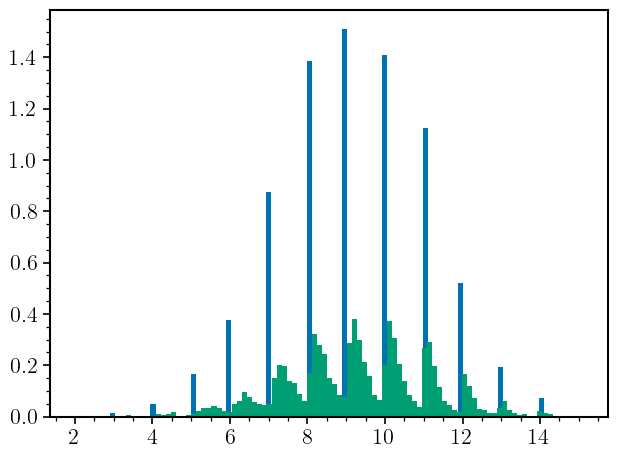

In [20]:
df = data_list[5].df_cn_o_carboxy_about_ca_6_12
df_filt_cut = df.filter(regex="^ag2_\d+$").applymap(lambda x: 1 if x > 0.33 else 0).sum(axis=1)
df_filt = df.filter(regex="^ag2_\d+$").clip(0, 1).sum(axis=1)
weights = df["weight"]

mean_cut = np.average(df_filt_cut, weights=weights)
mean = np.average(df_filt, weights=weights)

print(f"Mean (cut): {mean_cut}")
print(f"Mean: {mean}")

# plot histogram
fig, ax = plt.subplots()
ax.hist(df_filt_cut, bins=100, density=True, weights=weights)
ax.hist(df_filt, bins=100, density=True, weights=weights)

In [21]:
# transform the data
dfs_ca = df_ion_adsorbed(
    data_list,
    d12_min=list_d12_min,
    d12_max=list_d12_max,
    method="hard",
    ion="ca",
)
dfs_bav_ca = stats_ca_adsorbed(dfs_ca)

# transform the data
dfs_na = df_ion_adsorbed(
    data_list,
    d12_min=list_d12_min,
    d12_max=list_d12_max,
    method="hard",
    ion="na",
)
dfs_bav_na = stats_ca_adsorbed(dfs_na)


Calculating Ca ion types:   0%|          | 0/6 [00:00<?, ?it/s]

Block averaging:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating Ca ion types:   0%|          | 0/6 [00:00<?, ?it/s]

Block averaging:   0%|          | 0/6 [00:00<?, ?it/s]

### Block average data for error estimates

Max block size is 1/20 of the data
8 Ca ions with max block size of 12016
	Bound block size: 5341 (N_blocks: 44)
16 Ca ions with max block size of 12657
	Bound block size: 9077 (N_blocks: 27)
32 Ca ions with max block size of 12534
	Bound block size: 6963 (N_blocks: 36)
64 Ca ions with max block size of 3372
	Bound block size: 2384 (N_blocks: 28)
128 Ca ions with max block size of 559
	Bound block size: 373 (N_blocks: 30)


/tmp/ipykernel_1281426/847798547.py:18: UserWarning: Dataframe 0 is empty.
  warnings.warn(f"Dataframe {i} is empty.")


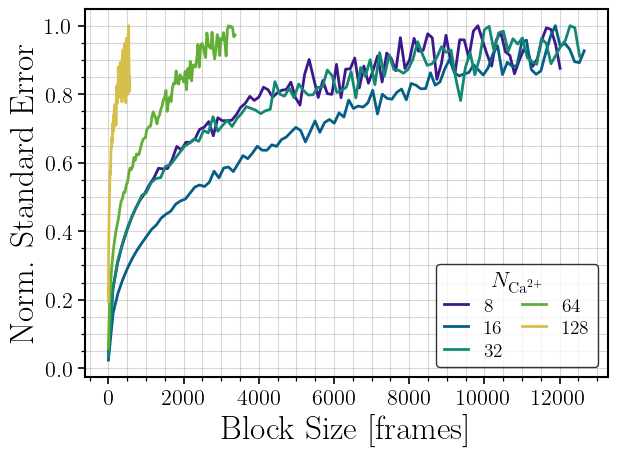

In [22]:
# data needed for future use
block_average_sizes = np.empty(len(dfs_bav_ca))
block_average_sizes.fill(np.nan)

# create figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="both", ls="-", alpha=0.5)

print(f"Max block size is 1/20 of the data")
cmap = cmr.take_cmap_colors("cmr.rainforest", N=6, cmap_range=(0.1, 0.8))
for i, df in enumerate(dfs_bav_ca):
    # attempt to extract the number of points and copy the dataframe
    try:
        n_pts = df.n_pts
        df = df.copy()
    except AttributeError:
        warnings.warn(f"Dataframe {i} is empty.")
        continue

    # ignore non-PAA data
    if data_list[i].info["monomer"].lower() != "acr":
        warnings.warn(f"Dataframe {i} is not PAA.")
        continue

    # extract data
    n_ca = data_list[i].info["n_Ca"]
    blocks = df["blocks"]
    # normalize the standard error
    err_bound = df["n_ca_bound_err"] / np.nanmax(df["n_ca_bound_err"])
    err_bridge = df["n_ca_bridge_err"] / np.nanmax(df["n_ca_bridge_err"])

    # find block size where the standard error first reaches at least 0.95
    idx_bound = np.where(err_bound >= 0.90)[0]
    if len(idx_bound) > 1:
        idx_bound = idx_bound[0]
    elif len(idx_bound) == 0:
        idx_bound = 0
        warnings.warn(f"Dataframe {i} has no bound block size.")
    n_bound_blocks = n_pts // blocks[idx_bound]
    block_average_sizes[i] = blocks[idx_bound]

    # idx_bridge = np.where(err_bridge >= 0.95)[0]
    # if len(idx_bridge) > 1:
    #     idx_bridge = idx_bridge[0]
    # elif len(idx_bridge) == 0:
    #     idx_bridge = 0
    #     warnings.warn(f"Dataframe {i} has no bridge block size.")
    # n_bridge_blocks = n_pts // blocks[idx_bridge]

    print(f"{n_ca} Ca ions with max block size of {np.nanmax(blocks)}")
    print(f"\tBound block size: {blocks[idx_bound]} (N_blocks: {n_bound_blocks})")
    # print(f"\tBridge block size: {blocks[idx_bridge]} (N_blocks: {n_bridge_blocks})")

    # plot data
    x = blocks.to_numpy() 
    y = err_bound.to_numpy()
    ax.plot(x, y, label=f"{n_ca}", linestyle="-", color=cmap[i])
    # ax.plot(blocks, err_bridge, label=f"Bridge: {n_ca}", linestyle="--", color=cmap[i])

# plot elements
ax.set_xlabel("Block Size [frames]")
ax.set_ylabel("Norm. Standard Error")
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
ax.set_title("Bound Calcium Ions", y=1.03)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / "block_size_nca_bound.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / "block_size_nca_bound.pdf", dpi=1200)


In [23]:
# show block sizes
print(f"Block sizes: {block_average_sizes}")

Block sizes: [  nan 5341. 9077. 6963. 2384.  373.]


### Plot the data

44    4.313114
Name: n_ca_bound, dtype: float64
71    6.435149
Name: n_ca_bound, dtype: float64
55    6.827262
Name: n_ca_bound, dtype: float64
70    8.192474
Name: n_ca_bound, dtype: float64
66    8.889187
Name: n_ca_bound, dtype: float64


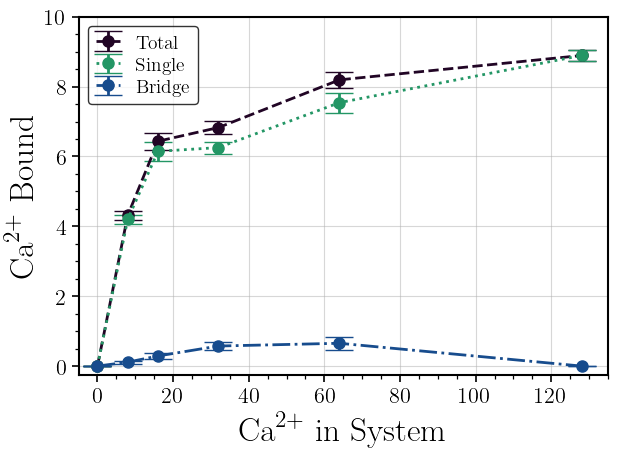

In [24]:
# create figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", ls="-", alpha=0.5)
cmap = cmr.take_cmap_colors("cmr.rainforest", N=4, cmap_range=(0.1, 0.8))


# extract data
n_ca = np.empty(len(dfs_bav_ca))
means = np.empty((len(dfs_bav_ca), 3))
means.fill(np.nan)
errs = np.empty((len(dfs_bav_ca), 3))
errs.fill(np.nan)

# set first row to zero
n_ca[0] = 0
means[0, :] = 0
errs[0, :] = 0

for i, df in enumerate(dfs_bav_ca):
    # skip non-PAA data or missing data
    if data_list[i].info["monomer"].lower() != "acr":
        continue
    elif data_list[i].info["n_Ca"] == 0:
        continue

    # collect statistics
    n_ca[i] = data_list[i].info["n_Ca"]
    idx_block_size = np.where(df["blocks"] == block_average_sizes[i])[0]
    if len(idx_block_size) > 1:
        idx_block_size = idx_block_size[0]
    elif len(idx_block_size) == 0:
        warnings.warn(f"Dataframe {i} has no block size.")
        continue
    print(df["n_ca_bound"].iloc[idx_block_size])
    means[i, 0] = df["n_ca_bound"].iloc[idx_block_size]
    means[i, 1] = df["n_ca_bridge"].iloc[idx_block_size]
    means[i, 2] = df["n_ca_shield"].iloc[idx_block_size]
    errs[i, 0] = df["n_ca_bound_err"].iloc[idx_block_size] * 1.96
    errs[i, 1] = df["n_ca_bridge_err"].iloc[idx_block_size] * 1.96
    errs[i, 2] = df["n_ca_shield_err"].iloc[idx_block_size] * 1.96

# plot data
ax.errorbar(
    n_ca,
    means[:, 0],
    yerr=errs[:, 0],
    label="Total",
    linestyle="--",
    fmt="o",
    markersize=8,
    capsize=10,
    color=cmap[0],
)
ax.errorbar(
    n_ca,
    means[:, 2],
    yerr=errs[:, 2],
    label="Single",
    linestyle=":",
    fmt="o",
    markersize=8,
    capsize=10,
    color=cmap[2],
)
ax.errorbar(
    n_ca,
    means[:, 1],
    yerr=errs[:, 1],
    label="Bridge",
    linestyle="-.",
    fmt="o",
    markersize=8,
    capsize=10,
    color=cmap[1],
)

# convert to dataframe and output to csv
df = pd.DataFrame({
    "n_ca": n_ca,
    "n_ca_bound": means[:, 0],
    "n_ca_bound_err": errs[:, 0],
    "n_ca_bridge": means[:, 1],
    "n_ca_bridge_err": errs[:, 1],
    "n_ca_shield": means[:, 2],
    "n_ca_shield_err": errs[:, 2],
})
df.to_parquet(dir_data / "n_ca_bound.parquet")
df_ca_bound = df.copy()

# plot elements
# ax.yaxis.set_minor_locator(MaxNLocator(integer=True))
# ax.grid(True, which="both", ls="-", alpha=0.5)
ax.set_xlabel(r"${\mathrm{Ca}^{2+}}$ in System")
ax.set_ylabel(r"${\mathrm{Ca}^{2+}}$ Bound")
ax.set_ylim(-0.25, 10)
ax.set_xlim(-5, 135)
ax.set_title("Two Associated PAA 16-mer", y=1.03)
ax.legend(loc="best")
fig.tight_layout()

# save figure
fig.savefig(dir_figures / "nca_bound.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / "nca_bound.pdf", dpi=1200)


Max block size is 1/20 of the data
0 Ca ions with max block size of 11995
	Bound block size: 9814 (N_blocks: 24)
8 Ca ions with max block size of 12016
	Bound block size: 6069 (N_blocks: 39)
16 Ca ions with max block size of 12657
	Bound block size: 9716 (N_blocks: 26)
32 Ca ions with max block size of 12534
	Bound block size: 7849 (N_blocks: 31)
64 Ca ions with max block size of 3372
	Bound block size: 2350 (N_blocks: 28)
128 Ca ions with max block size of 559
	Bound block size: 305 (N_blocks: 36)


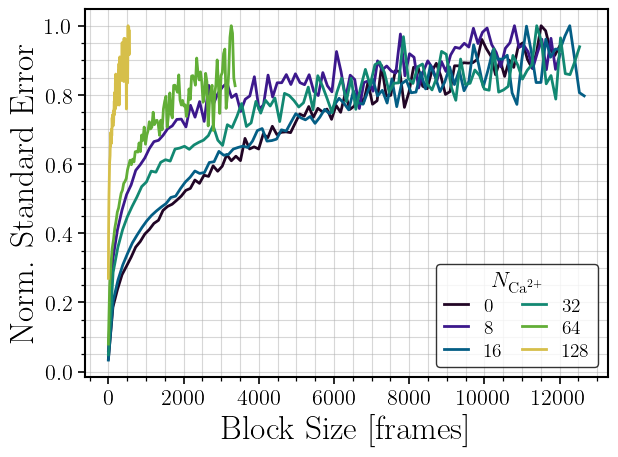

In [25]:
# data needed for future use
block_average_sizes = np.empty(len(dfs_bav_na))
block_average_sizes.fill(np.nan)

# create figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="both", ls="-", alpha=0.5)

print(f"Max block size is 1/20 of the data")
cmap = cmr.take_cmap_colors("cmr.rainforest", N=6, cmap_range=(0.1, 0.8))
for i, df in enumerate(dfs_bav_na):
    # attempt to extract the number of points and copy the dataframe
    try:
        n_pts = df.n_pts
        df = df.copy()
    except AttributeError:
        warnings.warn(f"Dataframe {i} is empty.")
        continue

    # ignore non-PAA data
    if data_list[i].info["monomer"].lower() != "acr":
        warnings.warn(f"Dataframe {i} is not PAA.")
        continue

    # extract data
    n_ca = data_list[i].info["n_Ca"]
    blocks = df["blocks"]
    # normalize the standard error
    err_bound = df["n_ca_bound_err"] / np.nanmax(df["n_ca_bound_err"])
    err_bridge = df["n_ca_bridge_err"] / np.nanmax(df["n_ca_bridge_err"])

    # find block size where the standard error first reaches at least 0.95
    idx_bound = np.where(err_bound >= 0.90)[0]
    if len(idx_bound) > 1:
        idx_bound = idx_bound[0]
    elif len(idx_bound) == 0:
        idx_bound = 0
        warnings.warn(f"Dataframe {i} has no bound block size.")
    n_bound_blocks = n_pts // blocks[idx_bound]
    block_average_sizes[i] = blocks[idx_bound]

    # idx_bridge = np.where(err_bridge >= 0.95)[0]
    # if len(idx_bridge) > 1:
    #     idx_bridge = idx_bridge[0]
    # elif len(idx_bridge) == 0:
    #     idx_bridge = 0
    #     warnings.warn(f"Dataframe {i} has no bridge block size.")
    # n_bridge_blocks = n_pts // blocks[idx_bridge]

    print(f"{n_ca} Ca ions with max block size of {np.nanmax(blocks)}")
    print(f"\tBound block size: {blocks[idx_bound]} (N_blocks: {n_bound_blocks})")
    # print(f"\tBridge block size: {blocks[idx_bridge]} (N_blocks: {n_bridge_blocks})")

    # plot data
    x = blocks.to_numpy() 
    y = err_bound.to_numpy()
    ax.plot(x, y, label=f"{n_ca}", linestyle="-", color=cmap[i])
    # ax.plot(blocks, err_bridge, label=f"Bridge: {n_ca}", linestyle="--", color=cmap[i])

# plot elements
ax.set_xlabel("Block Size [frames]")
ax.set_ylabel("Norm. Standard Error")
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
ax.set_title("Bound Calcium Ions", y=1.03)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / "block_size_nna_bound.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / "block_size_nna_bound.pdf", dpi=1200)


81    5.065429
Name: n_ca_bound, dtype: float64
50    2.494653
Name: n_ca_bound, dtype: float64
76    1.577327
Name: n_ca_bound, dtype: float64
62    0.981707
Name: n_ca_bound, dtype: float64
69    0.796611
Name: n_ca_bound, dtype: float64
54    0.592259
Name: n_ca_bound, dtype: float64


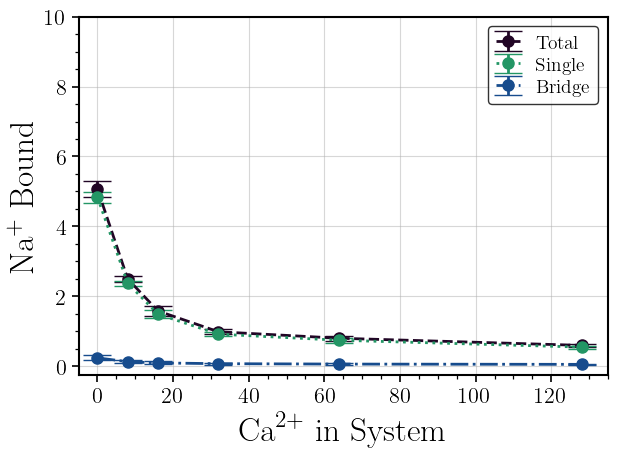

In [26]:
# create figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", ls="-", alpha=0.5)
cmap = cmr.take_cmap_colors("cmr.rainforest", N=4, cmap_range=(0.1, 0.8))

# extract data
n_ca = np.empty(len(dfs_bav_na))
means = np.empty((len(dfs_bav_na), 3))
means.fill(np.nan)
errs = np.empty((len(dfs_bav_na), 3))
errs.fill(np.nan)

# set first row to zero
n_ca[0] = 0
# means[0, :] = 0
# errs[0, :] = 0

for i, df in enumerate(dfs_bav_na):
    # skip non-PAA data or missing data
    if data_list[i].info["monomer"].lower() != "acr":
        continue

    # collect statistics
    n_ca[i] = data_list[i].info["n_Ca"]
    idx_block_size = np.where(df["blocks"] == block_average_sizes[i])[0]
    if len(idx_block_size) > 1:
        idx_block_size = idx_block_size[0]
    elif len(idx_block_size) == 0:
        warnings.warn(f"Dataframe {i} has no block size.")
        continue
    print(df["n_ca_bound"].iloc[idx_block_size])
    means[i, 0] = df["n_ca_bound"].iloc[idx_block_size]
    means[i, 1] = df["n_ca_bridge"].iloc[idx_block_size]
    means[i, 2] = df["n_ca_shield"].iloc[idx_block_size]
    errs[i, 0] = df["n_ca_bound_err"].iloc[idx_block_size] * 1.96
    errs[i, 1] = df["n_ca_bridge_err"].iloc[idx_block_size] * 1.96
    errs[i, 2] = df["n_ca_shield_err"].iloc[idx_block_size] * 1.96

# plot data
ax.errorbar(
    n_ca,
    means[:, 0],
    yerr=errs[:, 0],
    label="Total",
    linestyle="--",
    fmt="o",
    markersize=8,
    capsize=10,
    color=cmap[0],
)
ax.errorbar(
    n_ca,
    means[:, 2],
    yerr=errs[:, 2],
    label="Single",
    linestyle=":",
    fmt="o",
    markersize=8,
    capsize=10,
    color=cmap[2],
)
ax.errorbar(
    n_ca,
    means[:, 1],
    yerr=errs[:, 1],
    label="Bridge",
    linestyle="-.",
    fmt="o",
    markersize=8,
    capsize=10,
    color=cmap[1],
)

# plot elements
# ax.yaxis.set_minor_locator(MaxNLocator(integer=True))
# ax.grid(True, which="both", ls="-", alpha=0.5)
ax.set_xlabel(r"${\mathrm{Ca}^{2+}}$ in System")
ax.set_ylabel(r"${\mathrm{Na}^{+}}$ Bound")
ax.set_ylim(-0.25, 10)
ax.set_xlim(-5, 135)
ax.set_title("Two Associated PAA 16-mer", y=1.03)
ax.legend(loc="best")
fig.tight_layout()

# save figure
fig.savefig(dir_figures / "nna_bound.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / "nna_bound.pdf", dpi=1200)


## Plot the average Rg of the chains when associated as a function of the number of Ca ions in the system 

### Functions to transform the data

In [27]:
def df_rg_avg(
    data: list[Data], d12_min: list[float], d12_max: list[float]
) -> list[pd.DataFrame]:
    """
    Iterates through data dataclasses and returns a list of dataframes
    containing the average radius of gyration for each frame in the
    trajectory along with its associated weight from the enhanced
    sampling bias.

    The frames returned are where the chains are "associated" as defined
    by the d12_min and d12_max parameters.

    Parameters
    ----------
    data : list[Data]
        List of Data dataclasses.
    d12_min : list[float]
        Minimum d12 value for a frame to be considered "associated".
    d12_max : list[float]
        Maximum d12 value for a frame to be considered "associated".

    Returns
    -------
    list[pd.DataFrame]
        List of dataframes containing the average radius of gyration
        for each frame in the trajectory along with its associated
        weight from the enhanced sampling bias.

    Raises
    ------
    ValueError
        If the length of d12_min and d12_max are not equal.
    ValueError
        If the length of d12_min and d12_max are not equal to the
        number of dataclasses in data.
    """
    # check input
    if len(d12_min) != len(d12_max):
        raise ValueError("d12_min and d12_max must be the same length.")
    if len(d12_min) != len(data):
        raise ValueError("d12_min and d12_max must be the same length as data.")

    dfs = [None] * len(data)
    for i, dat in tqdm(
        enumerate(data), total=len(data), desc="Calculating average Rg", colour="green"
    ):
        # get dataframe
        try:
            df_a = dat.df_rg_a
            df_b = dat.df_rg_b
        except AttributeError:
            continue

        # merge dataframes
        df = pd.merge(df_a, df_b, on="frame", suffixes=("_a", "_b"))

        # drop rows where d12 is outside the "associated" range
        df = df[(df["d12_a"] >= d12_min[i]) & (df["d12_a"] <= d12_max[i])]

        # vertically stack the weights
        # weights = np.vstack((df["weight_a"].to_numpy(), df["weight_b"].to_numpy())).flatten()
        # vals = np.vstack((df["rg_a"].to_numpy(), df["rg_b"].to_numpy())).flatten()
        weights = df["weight_a"].to_numpy()
        vals = df["rg_a"].to_numpy() + df["rg_b"].to_numpy()
        vals /= 2.0

        # construct a new dataframe
        out = pd.DataFrame(
            {
                "rg_avg": vals,
                "weight": weights,
            }
        )

        dfs[i] = out

    return dfs


In [28]:
def stats_rg_avg(dfs_in: list[pd.DataFrame]) -> list[pd.DataFrame]:
    """
    Iterates through a list of dataframes containing the average radius
    of gyration for each frame in the trajectory along with its
    associated weight from the enhanced sampling bias. Returns a list
    of dataframes containing the average radius of gyration for each
    block size along with its associated error.

    Parameters
    ----------
    dfs_in : list[pd.DataFrame]
        List of dataframes containing the average radius of gyration
        for each frame in the trajectory along with its associated
        weight from the enhanced sampling bias.

    Returns
    -------
    list[pd.DataFrame]
        List of dataframes containing the average radius of gyration
        for each block size along with its associated error.
    """

    dfs = [None] * len(dfs_in)
    for i, df in tqdm(
        enumerate(dfs_in), total=len(dfs_in), desc="Block averaging", colour="green"
    ):
        try:
            df = df.copy()
        except AttributeError:
            continue

        blocks = np.linspace(1, len(df) // 20, 100, dtype=int)
        means, errs = [None], [None]

        for j, col in enumerate(["rg_avg"]):
            bav = BlockError(blocks, df[col].to_numpy(), df["weight"].to_numpy())
            means[j], errs[j] = bav.x_val()

        out = pd.DataFrame(
            {
                "blocks": blocks,
                "rg_avg": means[0],
                "rg_avg_err": errs[0],
            }
        )
        out.n_pts = len(df)

        dfs[i] = out

    return dfs


### Analysis

In [29]:
# transform the data
dfs_rg = df_rg_avg(
    data_list,
    d12_min=list_d12_min,
    d12_max=list_d12_max,
)
dfs_bav_rg = stats_rg_avg(dfs_rg)


Calculating average Rg:   0%|          | 0/6 [00:00<?, ?it/s]

Block averaging:   0%|          | 0/6 [00:00<?, ?it/s]

0 Ca ions with max block size of 11995
	Bound block size: 8602 (N_blocks: 27)
8 Ca ions with max block size of 12016
	Bound block size: 8981 (N_blocks: 26)
16 Ca ions with max block size of 12657
	Bound block size: 10228 (N_blocks: 24)
32 Ca ions with max block size of 12534
	Bound block size: 10128 (N_blocks: 24)
64 Ca ions with max block size of 3372
	Bound block size: 2622 (N_blocks: 25)
128 Ca ions with max block size of 559
	Bound block size: 429 (N_blocks: 26)


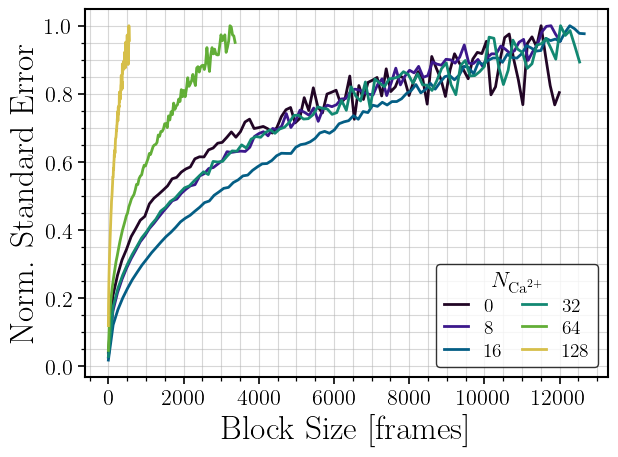

In [30]:
# data needed for future use
block_average_sizes = np.empty(len(dfs_bav_rg))
block_average_sizes.fill(np.nan)

# create figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="both", ls="-", alpha=0.5)

cmap = cmr.take_cmap_colors("cmr.rainforest", N=6, cmap_range=(0.1, 0.8))

for i, df in enumerate(dfs_bav_rg):
    # attempt to extract the number of points and copy the dataframe
    try:
        n_pts = df.n_pts
        df = df.copy()
    except AttributeError:
        warnings.warn(f"Dataframe {i} is empty.")
        continue

    # ignore non-PAA data
    if data_list[i].info["monomer"].lower() != "acr":
        warnings.warn(f"Dataframe {i} is not PAA.")
        continue

    # extract data
    n_ca = data_list[i].info["n_Ca"]
    blocks = df["blocks"]
    # normalize the standard error
    err_bound = df["rg_avg_err"] / np.nanmax(df["rg_avg_err"])

    # find block size where the standard error first reaches at least 0.95
    idx_bound = np.where(err_bound >= 0.90)[0]
    if len(idx_bound) > 1:
        idx_bound = idx_bound[0]
    elif len(idx_bound) == 0:
        idx_bound = 0
        warnings.warn(f"Dataframe {i} has no bound block size.")
    n_bound_blocks = n_pts // blocks[idx_bound]
    block_average_sizes[i] = blocks[idx_bound]

    # print some info
    print(f"{n_ca} Ca ions with max block size of {np.nanmax(blocks)}")
    print(f"\tBound block size: {blocks[idx_bound]} (N_blocks: {n_bound_blocks})")

    # plot data
    x = blocks.to_numpy()
    y = err_bound.to_numpy()
    ax.plot(x, y, label=f"{n_ca}", linestyle="-", color=cmap[i])

# plot elements
ax.set_xlabel("Block Size [frames]")
ax.set_ylabel("Norm. Standard Error")
ax.set_title(r"$\overline{R_g}$", y=1.03)
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / "block_size_rg_avg.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / "block_size_rg_avg.pdf", dpi=1200)


In [31]:
# show block sizes
print(f"Block sizes: {block_average_sizes}")


Block sizes: [ 8602.  8981. 10228. 10128.  2622.   429.]


### Plot the data

/tmp/ipykernel_1281426/3387891733.py:20: UserWarning: Dataframe 0 has no Ca ions.
  warnings.warn(f"Dataframe {i} has no Ca ions.")


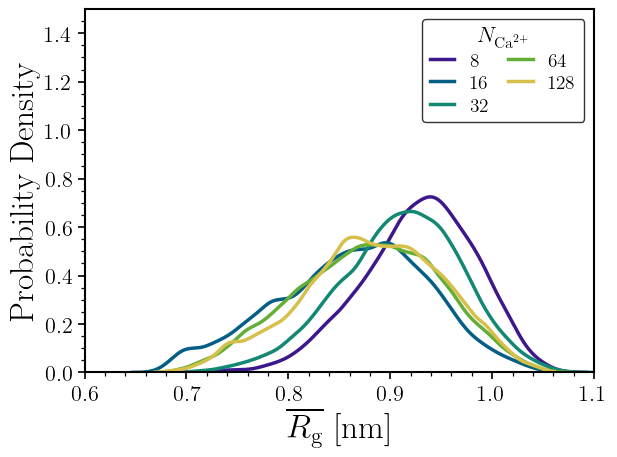

In [32]:
# create figure
fig = plt.figure()
ax = fig.add_subplot(111)

# calculate PDF(Mean(Rg))
cmap = cmr.take_cmap_colors("cmr.rainforest", N=6, cmap_range=(0.1, 0.8))
for i, df in enumerate(dfs_rg):
    # attempt to extract the number of points and copy the dataframe
    try:
        df = df.copy()
    except AttributeError:
        warnings.warn(f"Dataframe {i} is empty.")
        continue

    # ignore non-PAA data
    if data_list[i].info["monomer"].lower() != "acr":
        warnings.warn(f"Dataframe {i} is not PAA.")
        continue
    if data_list[i].info["n_Ca"] == 0:
        warnings.warn(f"Dataframe {i} has no Ca ions.")
        continue

    # extract data
    n_ca = data_list[i].info["n_Ca"]

    # calculate PDF with KDE
    block = np.array([block_average_sizes[i]], dtype=int)
    d, w = df["rg_avg"].to_numpy(), df["weight"].to_numpy()
    bav = BlockError(block, d, w)
    pts, pdf, _, err = bav.x_kde(n_pts=500, bandwidth=0.07)
    pdf = pdf[-1]
    err = err[-1]

    # plot data
    ax.plot(pts / 10.0, pdf, label=f"{n_ca}", color=cmap[i], linewidth=2.5)
    # ax.fill_between(
        # pts / 10.0, pdf - 1.96 * err, pdf + 1.96 * err, alpha=0.05, color=cmap[i]
    # )


# plot elements
ax.set_xlabel(r"$\overline{R_\mathrm{g}}$ [nm]")
ax.set_xlim(0.6, 1.1)
ax.set_ylabel("Probability Density")
ax.set_ylim(0, 1.5)
ax.set_title("Two Associated PAA 16-mer", y=1.03)
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / "rg_avg_pdf.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / "rg_avg_pdf.pdf", dpi=1200)

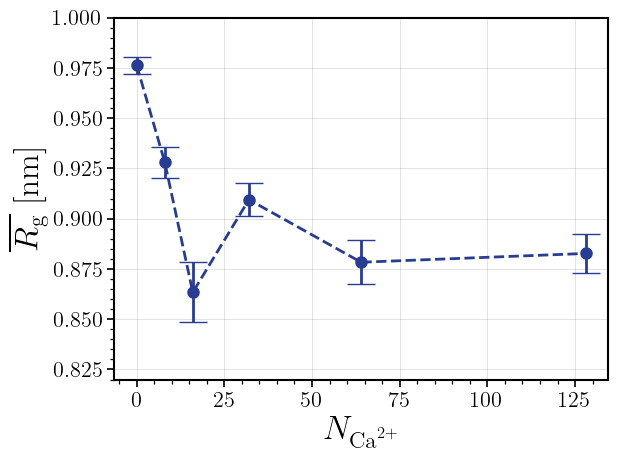

In [33]:
# create figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(visible=True, which="major",
           linestyle="-", linewidth=0.5, alpha=0.5)
cmap = cmr.take_cmap_colors("cmr.rainforest", N=3, cmap_range=(0.3, 0.8))

# calculate PDF(Mean(Rg))
x, y, yerr = [], [], []
for i, df in enumerate(dfs_rg):
    # attempt to extract the number of points and copy the dataframe
    try:
        df = df.copy()
    except AttributeError:
        warnings.warn(f"Dataframe {i} is empty.")
        continue

    # ignore non-PAA data
    if data_list[i].info["monomer"].lower() != "acr":
        warnings.warn(f"Dataframe {i} is not PAA.")
        continue

    # extract data
    n_ca = data_list[i].info["n_Ca"]

    # calculate PDF with KDE
    block = np.array([block_average_sizes[i]], dtype=int)
    d, w = df["rg_avg"].to_numpy(), df["weight"].to_numpy()
    bav = BlockError(block, d, w)
    means, errs = bav.x_val()
    mean, err = means[-1], errs[-1]
    x.append(n_ca)
    y.append(mean / 10.)
    yerr.append(err / 10.)
    
x = np.array(x)
y = np.array(y)
yerr = np.array(yerr)

# plot data
ax.errorbar(x, y, yerr=1.96*yerr,
            linestyle="--", fmt="o", markersize=8, capsize=10, color=cmap[0])

# plot elements
ax.set_xlabel(r"$N_{\mathrm{Ca}^{2+}}$")
ax.set_ylabel(r"$\overline{R_\mathrm{g}}$ [nm]")
ax.set_ylim(bottom=0.82, top=1.0)
ax.set_title("Two Associated PAA 16-mer", y=1.03)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / "rg_avg_vs_nca.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / "rg_avg_vs_nca.pdf", dpi=1200)

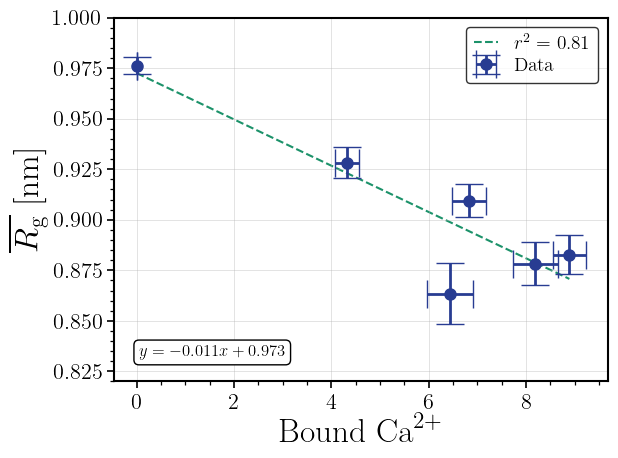

In [34]:
# create figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(visible=True, which="major",
           linestyle="-", linewidth=0.5, alpha=0.5)

# calculate PDF(Mean(Rg))
x, y, yerr = [], [], []
for i, df in enumerate(dfs_rg):
    # attempt to extract the number of points and copy the dataframe
    try:
        df = df.copy()
    except AttributeError:
        warnings.warn(f"Dataframe {i} is empty.")
        continue

    # ignore non-PAA data
    if data_list[i].info["monomer"].lower() != "acr":
        warnings.warn(f"Dataframe {i} is not PAA.")
        continue

    # extract data
    n_ca = data_list[i].info["n_Ca"]

    # calculate PDF with KDE
    block = np.array([block_average_sizes[i]], dtype=int)
    d, w = df["rg_avg"].to_numpy(), df["weight"].to_numpy()
    bav = BlockError(block, d, w)
    means, errs = bav.x_val()
    mean, err = means[-1], errs[-1]
    y.append(mean / 10.)
    yerr.append(err / 10.)
    
y = np.array(y)
yerr = np.array(yerr)

# get x-values from df_ca_bound
x = df_ca_bound["n_ca_bound"].to_numpy()
xerr = df_ca_bound["n_ca_bound_err"].to_numpy()

# calculate best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# plot data
ax.errorbar(x, y, yerr=1.96*yerr, xerr=1.96*xerr,
            linestyle="", fmt="o",
            markersize=8, capsize=10, color=cmap[0],
            zorder=1, label="Data")

# add best fit line
ax.plot(x, intercept + slope*x,
        "--", lw=1.5,
        label=f"$r^2 = $ {r_value**2:.2f}", color=cmap[1],
        zorder=0)

# plot elements
ax.set_xlabel(r"Bound $\mathrm{Ca}^{2+}$")
ax.set_ylabel(r"$\overline{R_\mathrm{g}}$ [nm]")
ax.set_ylim(bottom=0.82, top=1.0)
ax.legend(loc="upper right")
ax.set_title("Two Associated PAA 16-mer", y=1.03)
fig.tight_layout()

# add textbox for best fit line
ax.text(0.05, 0.10, f"$y = {slope:.3f}x + {intercept:.3f}$",
        transform=ax.transAxes, fontsize=12, verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=1.0))

# save figure
fig.savefig(dir_figures / "rg_avg_vs_bound_ca.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / "rg_avg_vs_bound_ca.pdf", dpi=1200)

## Plot the coordination number of polymer carboxylate groups as a function of the number of Ca ions in the system

In [35]:
def df_cn_to_kde(
    df: pd.DataFrame,
    block_size: int = 100,
    bandwidth: float = 0.1,
    x_min: float = None,
    x_max: float = None,
    cutoff: float = 0.5,
):
    ca_cols = [col for col in df.columns if col.startswith("ag2_")]
    n_ca = len(ca_cols)
    
    coordination = df.filter(regex="^ag2_\d+$").to_numpy().flatten()
    weights = np.tile(df["weight"].to_numpy(), n_ca)
    
    # drop coordination entries below cutoff
    idx_keep = np.where(coordination >= cutoff)[0]
    coordination = coordination[idx_keep]
    weights = weights[idx_keep]
    
     
    # calculate PDF with KDE
    bav = BlockError([block_size], coordination, weights=weights)
    pts, pdf, _, err = bav.x_kde(n_pts=1000, bandwidth=bandwidth, x_min=x_min, x_max=x_max)
    
    return pts, pdf, err


  0%|          | 0/6 [00:00<?, ?it/s]

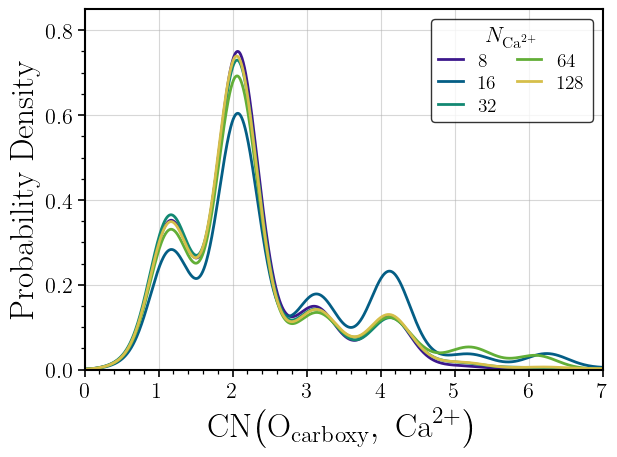

In [36]:

blocks = block_average_sizes
bandwidth = 0.25
x_min = 0
cmap = cmr.take_cmap_colors("cmr.rainforest", 6, cmap_range=(0.1, 0.8))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    if dat.info["n_Ca"] == 0:
        continue
    elif dat.info["monomer"].lower() != "acr":
        continue
        
    block_size = int(blocks[i] * dat.info["n_Ca"] * 0.01)
    if block_size < 1:
        block_size = 1
    elif dat.info["n_Ca"] == 128:
        block_size = 2
    
    # REVIEW: this is the data source
    df = dat.df_cn_o_carboxy_about_ca_6_12.copy()
    
    pts, pdf, err = df_cn_to_kde(df, block_size=block_size * dat.info["n_Ca"], bandwidth=bandwidth, x_min=x_min,
                                 cutoff=0.5)
    pdf, err = pdf[-1], err[-1] # last entry as we only test 1 block size
    ax.plot(pts, pdf, label=dat.info["n_Ca"], color=cmap[i])
    # ax.fill_between(pts, pdf - 1.96 * err, pdf + 1.96 * err, alpha=0.1, color=cmap[i])

# plot elements
ax.set_xlabel(r"$\mathrm{CN}{\left(\mathrm{O}_\mathrm{carboxy},~\mathrm{Ca}^{2+}\right)}$")
ax.set_xlim(0, 7)
ax.set_ylabel("Probability Density")
ax.set_ylim(0, 0.85)
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
filename = "cn_o_carboxy_about_ca_6_12_pdf"
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

  0%|          | 0/6 [00:00<?, ?it/s]

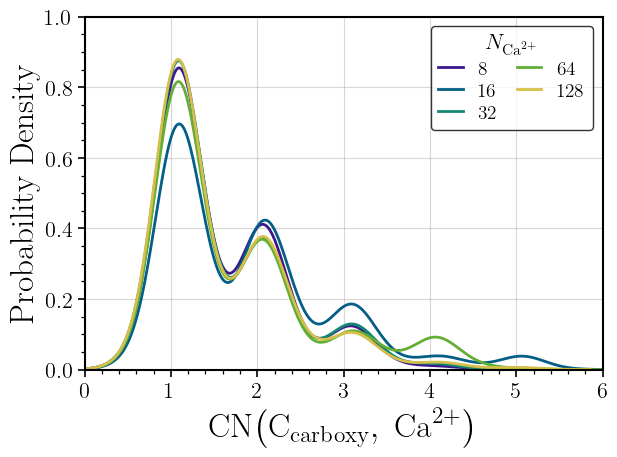

In [37]:
blocks = block_average_sizes

bandwidth = 0.25
x_min = 0
cmap = cmr.take_cmap_colors("cmr.rainforest", 6, cmap_range=(0.1, 0.8))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    if dat.info["n_Ca"] == 0:
        continue
    elif dat.info["monomer"].lower() != "acr":
        continue
    
    block_size = int(blocks[i] * dat.info["n_Ca"] * 0.1)
    
    # REVIEW: this is the data source
    df = dat.df_cn_c_carboxy_about_ca_6_12.copy()
    
    pts, pdf, err = df_cn_to_kde(df, block_size=block_size, bandwidth=bandwidth, x_min=x_min)
    pdf, err = pdf[-1], err[-1] # last entry as we only test 1 block size
    ax.plot(pts, pdf, label=dat.info["n_Ca"], color=cmap[i])
    # ax.fill_between(pts, pdf - 1.96 * err, pdf + 1.96 * err, alpha=0.1, color=cmap[i])

# plot elements
ax.set_xlabel(r"$\mathrm{CN}{\left(\mathrm{C}_\mathrm{carboxy},~\mathrm{Ca}^{2+}\right)}$")
ax.set_xlim(0, 6)
ax.set_ylabel("Probability Density")
ax.set_ylim(0, 1)
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
filename = "cn_c_carboxy_about_ca_6_12_pdf"
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

  0%|          | 0/6 [00:00<?, ?it/s]

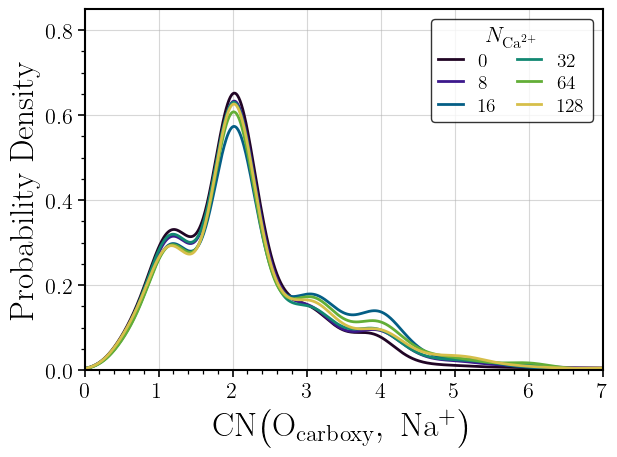

In [38]:

blocks = block_average_sizes
bandwidth = 0.25
x_min = 0
cmap = cmr.take_cmap_colors("cmr.rainforest", 6, cmap_range=(0.1, 0.8))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    if dat.info["monomer"].lower() != "acr":
        continue
    
    # REVIEW: this is the data source
    df = dat.df_cn_o_carboxy_about_na_6_12.copy()
    
    block_size = int(blocks[i] * dat.info["n_Na"] * 0.1)
    
    pts, pdf, err = df_cn_to_kde(df, block_size=block_size, bandwidth=bandwidth, x_min=x_min)
    pdf, err = pdf[-1], err[-1] # last entry as we only test 1 block size
    ax.plot(pts, pdf, label=dat.info["n_Ca"], color=cmap[i])
    # ax.fill_between(pts, pdf - 1.96 * err, pdf + 1.96 * err, alpha=0.1, color=cmap[i])

# plot elements
ax.set_xlabel(r"$\mathrm{CN}{\left(\mathrm{O}_\mathrm{carboxy},~\mathrm{Na}^{+}\right)}$")
ax.set_xlim(0, 7)
ax.set_ylabel("Probability Density")
ax.set_ylim(0, 0.85)
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
filename = "cn_o_carboxy_about_na_6_12_pdf"
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

  0%|          | 0/6 [00:00<?, ?it/s]

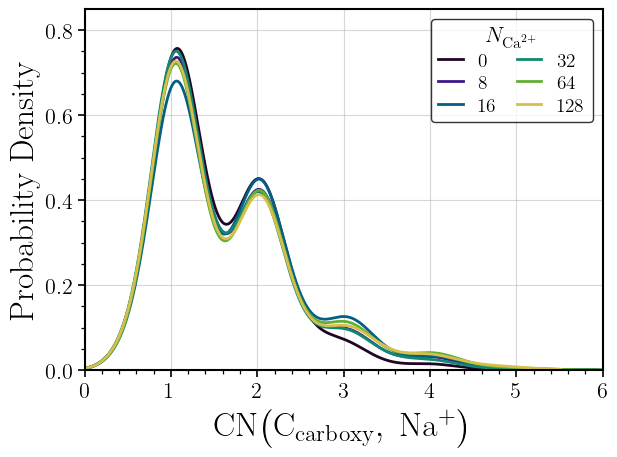

In [39]:
blocks = block_average_sizes
bandwidth = 0.25
x_min = 0
cmap = cmr.take_cmap_colors("cmr.rainforest", 6, cmap_range=(0.1, 0.8))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    
    if dat.info["monomer"].lower() != "acr":
        continue
    
    # REVIEW: this is the data source
    df = dat.df_cn_c_carboxy_about_na_6_12.copy()
    
    block_size = int(blocks[i] * dat.info["n_Na"] * 0.1)
    
    pts, pdf, err = df_cn_to_kde(df, block_size=block_size, bandwidth=bandwidth, x_min=x_min)
    pdf, err = pdf[-1], err[-1] # last entry as we only test 1 block size
    ax.plot(pts, pdf, label=dat.info["n_Ca"], color=cmap[i])
    # ax.fill_between(pts, pdf - 1.96 * err, pdf + 1.96 * err, alpha=0.1, color=cmap[i])

# plot elements
ax.set_xlabel(r"$\mathrm{CN}{\left(\mathrm{C}_\mathrm{carboxy},~\mathrm{Na}^{+}\right)}$")
ax.set_xlim(0, 6)
ax.set_ylabel("Probability Density")
ax.set_ylim(0, 0.85)
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
filename = "cn_c_carboxy_about_na_6_12_pdf"
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

## Plot the RDF of water about small ions as a function of Ca in the system

### Calcium ions

  0%|          | 0/6 [00:00<?, ?it/s]

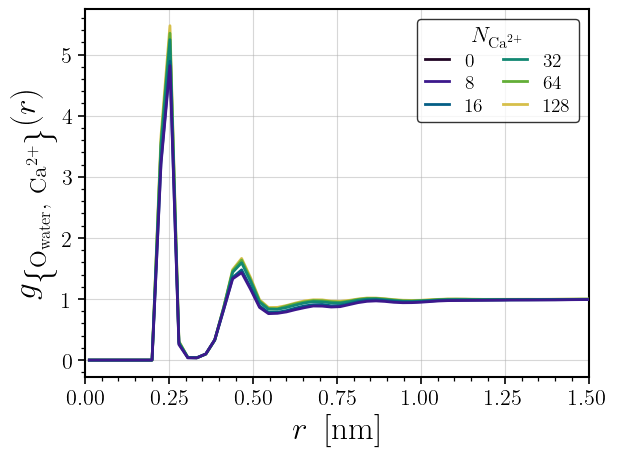

In [40]:
filename = "rdf_o_water_about_ca"
cmap = cmr.take_cmap_colors("cmr.rainforest", 6, cmap_range=(0.1, 0.8))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    
    # REVIEW: this is the data source
    df = dat.arr_rdf_o_water_about_ca.copy()

    x = df["bins"].to_numpy() / 10.
    y = df["rdf"].to_numpy()
    label = dat.info["n_Ca"]
    ax.plot(x, y, label=label, color=cmap[i], zorder=10-i)

# plot elements
ax.set_xlabel(r"$r~\left[\mathrm{nm}\right]$")
ax.set_xlim(0, 1.5)
ax.set_ylabel(r"$g_{\left\{\mathrm{O}_\mathrm{water},~\mathrm{Ca}^{2+}\right\}}{(r)}$")
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

  0%|          | 0/6 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/media/aglisman/ExFAT/sjobid_10071-PAcr-2chain-16mer-atactic-Hend-chain-em-0Na-0Ca-12.0nmbox-ion_pe_all_scaledEStatics-node01-2023-01-27-08\uf02232\uf02221.543949375/3-hremd-prod-16_replicas-100_steps-300_Kmin-440_Kmax/replica_00/2-trajectory-concatenation/nvt_hremd_prod_scaled.tpr'

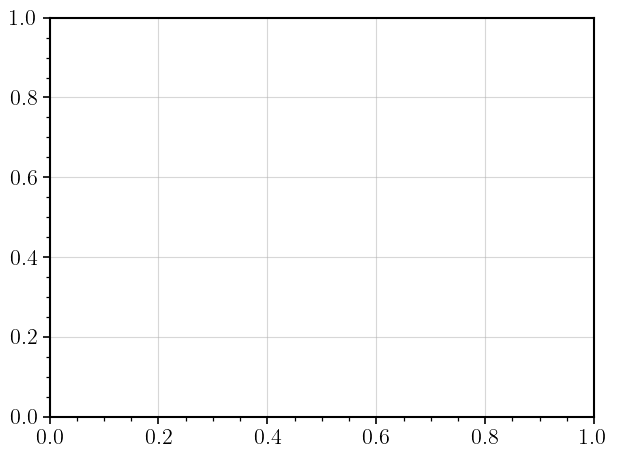

In [41]:
cmap = cmr.take_cmap_colors("cmr.rainforest", 6, cmap_range=(0.1, 0.8))
filename = "rdf_o_water_about_ca_coordination_number"
verbose = True

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    
    # REVIEW: this is the data source
    df = dat.arr_rdf_o_water_about_ca.copy()
    ion = "CA"
   
    # get water density from number of waters and box volume
    uni = mda.Universe(dat.info["f_top"], dat.info["f_trj"])
    vol = uni.dimensions[0] * uni.dimensions[1] * uni.dimensions[2]
    n_waters = uni.select_atoms("name OW").n_atoms
    n_ion = uni.select_atoms(f"resname {ion}").n_atoms
    n = n_waters * n_ion
    density = n_waters / vol  # [# waters / \AA^3]
    
    if verbose:
        print(f"Number of waters: {n_waters}")
        print(f"Number of {ion}: {n_ion}")
        print(f"Box volume: {vol}")
        print(f"Density: {density}")
        print()
  
    # calculate integrand and prefactor
    x = df["bins"].to_numpy() 
    y = df["rdf"].to_numpy()
    integrand = y * (x ** 2)  # [\AA^2]
    prefactor = 4. * np.pi * density  # [# waters / \AA^3]
    
    # numerically integrate to get coordination number
    cn = np.zeros_like(x)
    for j in range(len(x)):
        cn[j] = np.trapz(y[:j], x[:j])  # [\AA^3]

    y = cn * prefactor  # [# waters]
    x /= 10. # [\AA] -> [nm]
    
    # remove values where x > cutoff
    cutoff = 0.32
    y = y[x <= cutoff]
    x = x[x <= cutoff]
    
    label = dat.info["n_Ca"]
    ax.plot(x, y, label=label, color=cmap[i], zorder=10-i)

# plot elements
ax.set_xlabel(r"$r~\left[\mathrm{nm}\right]$")
ax.set_ylabel(r"$\mathrm{CN}_{\left\{\mathrm{O}_\mathrm{water},~\mathrm{Ca}^{2+}\right\}}{(r)}$")
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

### Sodium ions

In [ ]:
cmap = sns.color_palette("cividis", len(data_list) + 1)
filename = "rdf_o_water_about_na"

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    
    # REVIEW: this is the data source
    df = dat.arr_rdf_o_water_about_na.copy()

    x = df["bins"].to_numpy() / 10.
    y = df["rdf"].to_numpy()
    label = dat.info["n_Ca"]
    ax.plot(x, y, label=label, color=cmap[i], zorder=10-i)

# plot elements
ax.set_xlabel(r"$r~\left[\mathrm{nm}\right]$")
ax.set_xlim(0, 1.5)
ax.set_ylabel(r"$g_{\left\{\mathrm{O}_\mathrm{water},~\mathrm{Na}^{+}\right\}}{(r)}$")
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

### Adsorbed Calcium ions

In [ ]:
cmap = sns.color_palette("cividis", len(data_list) + 1)
filename = "rdf_o_water_about_ca_adsorbed"

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    
    # REVIEW: this is the data source
    df = dat.arr_rdf_o_water_about_ca_adsorbed.copy()

    x = df["bins"].to_numpy() / 10.
    y = df["rdf"].to_numpy()
    label = dat.info["n_Ca"]
    ax.plot(x, y, label=label, color=cmap[i], zorder=10-i)

# plot elements
ax.set_xlabel(r"$r~\left[\mathrm{nm}\right]$")
ax.set_xlim(0, 1.5)
ax.set_ylabel(r"$g_{\left\{\mathrm{O}_\mathrm{water},~\mathrm{Ca}^{2+}\right\}}{(r)}$")
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

## Plot the RDF and CN of C alpha atoms of one chain about the other

### RDF

In [ ]:
cmap = sns.color_palette("cividis", len(data_list) + 1)
filename = "rdf_c_alpha"

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    
    # REVIEW: this is the data source
    df = dat.arr_rdf_calpha.copy()

    x = df["bins"].to_numpy() / 10.
    y = df["rdf"].to_numpy()
    label = dat.info["n_Ca"]
    ax.plot(x, y, label=label, color=cmap[i], zorder=10-i)

# plot elements
ax.set_xlabel(r"$r~\left[\mathrm{nm}\right]$")
# ax.set_xlim(0, 1.5)
ax.set_ylabel(r"$g_{\left\{\mathrm{C}_{\alpha\mathrm{(A)}},~\mathrm{C}_{\alpha\mathrm{(B)}}\right\}}{(r)}$")
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)

### Contacts

In [ ]:
blocks = block_average_sizes
bandwidth = 0.1
cutoff = 0.1
x_min = 0
n_atoms = 1
cmap = sns.color_palette("cividis", len(data_list) + 1)
filename = "cn_c_alpha"

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.5)

for i, dat in tqdm(enumerate(data_list), total=len(data_list)):
    block_size = int(blocks[i] * n_atoms * 0.1)
    if dat.info["n_Ca"] == 128 and OPT == 0:
        block_size = int(2)
        continue
    elif OPT == 4:
        block_size = int(blocks[i] * n_atoms * 0.01)
        
    
    # REVIEW: this is the data source
    df = dat.df_cn_calpha_about_calpha.copy()
    print(f"Number of data points: {df.shape[0]}")
    print(f"Number of blocks: {df.shape[0] / block_size}")
    
    pts, pdf, err = df_cn_to_kde(
        df, 
        block_size=block_size,
        bandwidth=bandwidth, 
        x_min=x_min,
        cutoff=cutoff, 
        )
    pdf, err = pdf[-1], err[-1] # last entry as we only test 1 block size
    ax.plot(pts, pdf, label=dat.info["n_Ca"], color=cmap[i])
    ax.fill_between(pts, pdf - 1.96 * err, pdf + 1.96 * err, alpha=0.1, color=cmap[i])

# plot elements
ax.set_xlabel(r"$\mathrm{CN}{\left(\mathrm{C}_{\alpha\mathrm{(A)}},~\mathrm{C}_{\alpha\mathrm{(B)}}\right)}$")
# ax.set_xlim(0, 6)
ax.set_ylabel("Probability Density")
ax.legend(loc="best", title=r"$N_{\mathrm{Ca}^{2+}}$", ncol=2)
fig.tight_layout()

# save figure
fig.savefig(dir_figures / f"{filename}.png", dpi=600)

# remove title and save as PDF
ax.set_title("")
fig.tight_layout()
fig.savefig(dir_figures / f"{filename}.pdf", dpi=1200)